# ACP Project - Model Evaluation

## Setup

In [1]:
import warnings, pickle, os
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt

import seaborn as sns

import shap
import optuna

%load_ext autoreload
%autoreload 1

In [2]:
from utils.evaluation import f2_score, METRICS, evaluate, evaluate_from_pred, with_sampling_strategies, spotCheckCV, spotCheckDatasets, F2TabNet, joint_plot
from utils.isolation_forest_wrapper import IsolationForestWrapper
%aimport utils.evaluation

In [3]:
from hyperparameter_tuning import tune_xgboost, tune_tabnet, tune_lgbm, tune_randomforest, tune_isolationforest, tune_logisticregression
%aimport hyperparameter_tuning

In [4]:
class Notebook:
    IMAGE_DIR = "images/critical_event_48_missing_values"
    MODEL_DIR = "models/critical_event_48_missing_values"
    OUTCOME = "CriticalEvent"
    OUTCOME_WITHIN = 2

    SAVE_MODELS = True
    SAVE_IMAGES = True

    RUN_HYPERPARAMETERS = True
    HYPERPARAMETER_TIMEOUT = 60 * 60 * 2
    HYPERPARAMETER_NJOBS = 4

    SHAP_PLOTS_MAXDISPLAY = 20
    EVAL_N_RESAMPLES = 9999

    MODELS = {}
    EXPLAINERS = {}
    EVAL_RESULTS = {}
    TUNED_RESULTS = {}
    MORTALITY_RESULTS = {}
    CRITICALCARE_RESULTS = {}


In [5]:
try:
    os.makedirs(Notebook.IMAGE_DIR)
    os.makedirs(Notebook.MODEL_DIR)
except FileExistsError:
    pass


In [6]:
def restore():
    with open(f"{Notebook.MODEL_DIR}/models.bin", "rb") as file:
        Notebook.MODELS = pickle.load(file)

    with open(f"{Notebook.MODEL_DIR}/explainers.bin", "rb") as file:
        Notebook.EXPLAINERS = pickle.load(file)


### Dataset

In [7]:
from dataset import SCIData, SCICols
from utils.data_profiling import ensure_categorical_overlap, drop_exclusive_cols
%aimport dataset, utils.data_profiling

sci = (
    SCIData.load('data/sci_processed.h5')
    .fix_readmissionband()
    .derive_critical_event(within=Notebook.OUTCOME_WITHIN, return_subcols=True)
)
Notebook.OUTCOME = 'CriticalEvent'


In [8]:
from sklearn.model_selection import train_test_split

scii = (
    SCIData(sci.sort_values("AdmissionDateTime"))
    .omit_redundant()
    .drop(["ReadmissionBand", "AgeBand", "LastSpecialty"], axis=1)
    .omit_ae()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
)

sci_train, sci_test = train_test_split(
    scii, test_size=0.33, random_state=42, shuffle=False
)
y_test_mortality, y_test_criticalcare = (
    sci_test.DiedWithinThreshold.copy(),
    sci_test.CriticalCare.copy(),
)

if Notebook.OUTCOME == "CriticalEvent":
    sci_train, sci_test = (
        sci_train.drop(
            ["DiedWithinThreshold", "CriticalCare"], axis=1, errors="ignore"
        ),
        sci_test.drop(["DiedWithinThreshold", "CriticalCare"], axis=1, errors="ignore"),
    )

sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)

# Drop HSMR_15 as there is only 1 in the entire dataset, making a split impossible
(X_train, y_train), (X_test, y_test) = (
    sci_train.impute_blood()
    .encode_ccs_onehot()
    .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=False, fillna=True),
    sci_test.impute_blood()
    .encode_ccs_onehot()
    .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=False, fillna=True),
)
categorical_cols_idx, categorical_cols_dims = X_train.describe_categories()
drop_exclusive_cols(X_train, X_test)
ensure_categorical_overlap(X_train, X_test, categorical_cols_idx)

# Mandated vitals, Categorical diagnoses (main only)
(X_train_if, y_train_if), (X_test_if, y_test_if) = (
    sci_train.drop(SCICols.diagnoses[1:], axis=1).xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True
    ),
    sci_test.drop(SCICols.diagnoses[1:], axis=1).xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True
    ),
)
drop_exclusive_cols(X_train_if, X_test_if)

(X_train_lgbm, y_train_lgbm), (X_test_lgbm, y_test_lgbm) = (
    sci_train.encode_ccs_onehot().xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=False
    ),
    sci_test.encode_ccs_onehot().xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=False
    ),
)
drop_exclusive_cols(X_train_lgbm, X_test_lgbm)
ensure_categorical_overlap(X_train_lgbm, X_test_lgbm, categorical_cols_idx)

(X_train_tn, X_valid_tn, y_train_tn, y_valid_tn) = train_test_split(
    X_train.to_numpy(),
    y_train.to_numpy(),
    stratify=y_train,
    test_size=0.33,
    random_state=42,
)

(X_train_news, y_train_news), (X_test_news, y_test_news) = (
    sci_train.xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float, fillna=True
    ),
    sci_test.xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float, fillna=True
    ),
)
drop_exclusive_cols(X_train_news, X_test_news)


### Tuning

In [9]:
from sklearn.metrics import precision_recall_curve


def get_threshold(y_train, y_pred_proba, target=0.85):
    """ Given prediction probabilities, sets the prediction threshold to approach the given target recall
    """

    # Get candidate thresholds from the model, and find the one that gives the best fbeta score
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba)
    closest = thresholds[np.abs(recall - target).argmin()]

    return closest


## Models

### Baseline (NEWS)

Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.975723   0.242784  0.302326  0.269303   0.28819  0.825665   

            AUC_CI  
Model  0.804-0.847

array([[31045,   446],
       [  330,   143]])

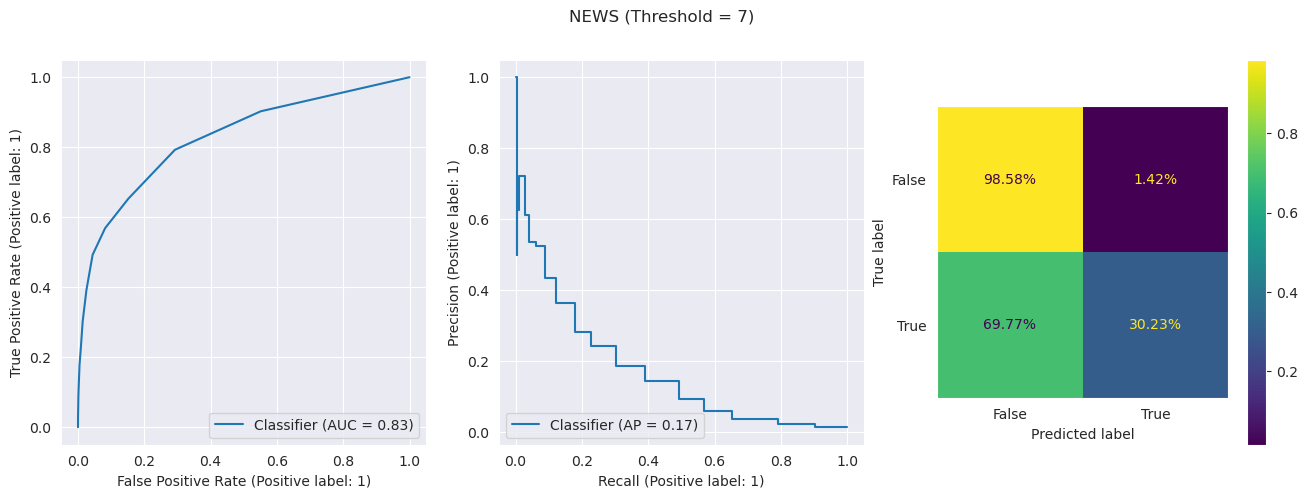

In [10]:
baseline_mask = sci[sci.c_NEWS_score.notna()].index.intersection(sci_test.index)
Notebook.EVAL_RESULTS["Baseline (NEWS)"] = evaluate_from_pred(
    y_test.loc[baseline_mask],
    y_pred=(sci.loc[baseline_mask].c_NEWS_score >= 7),
    y_pred_proba=(sci.loc[baseline_mask].c_NEWS_score),
    plot_title="NEWS (Threshold = 7)",
    save=f"{Notebook.IMAGE_DIR}/baseline_news.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.982386   0.203735  0.560748  0.298879  0.415225  0.924936   

            AUC_CI  
Model  0.903-0.945

array([[31281,   469],
       [   94,   120]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.975222   0.073005  0.148789   0.09795  0.123209  0.763438   

            AUC_CI  
Model  0.733-0.793

array([[31129,   546],
       [  246,    43]])

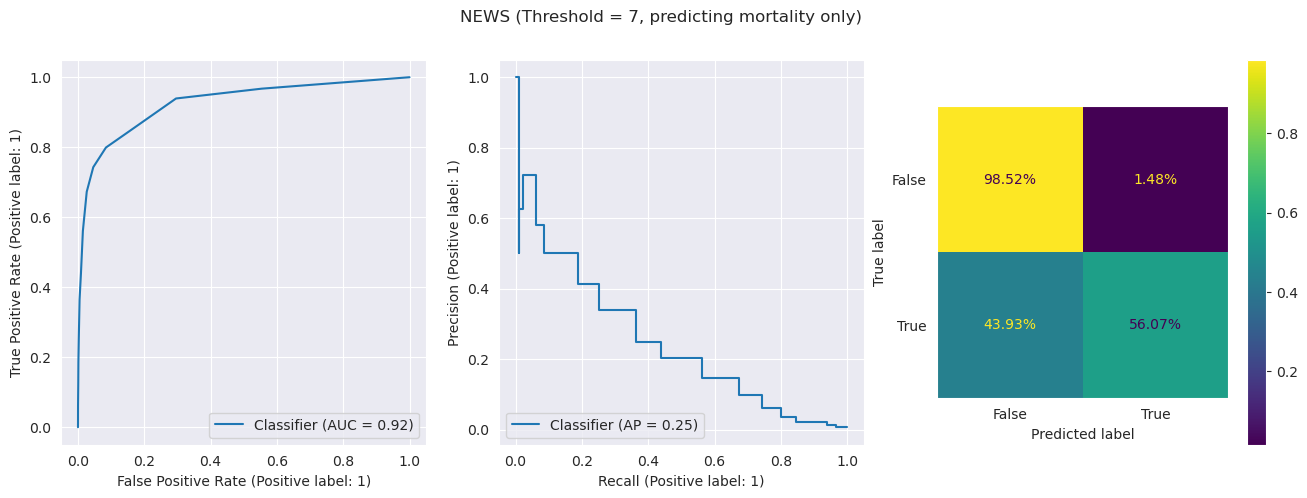

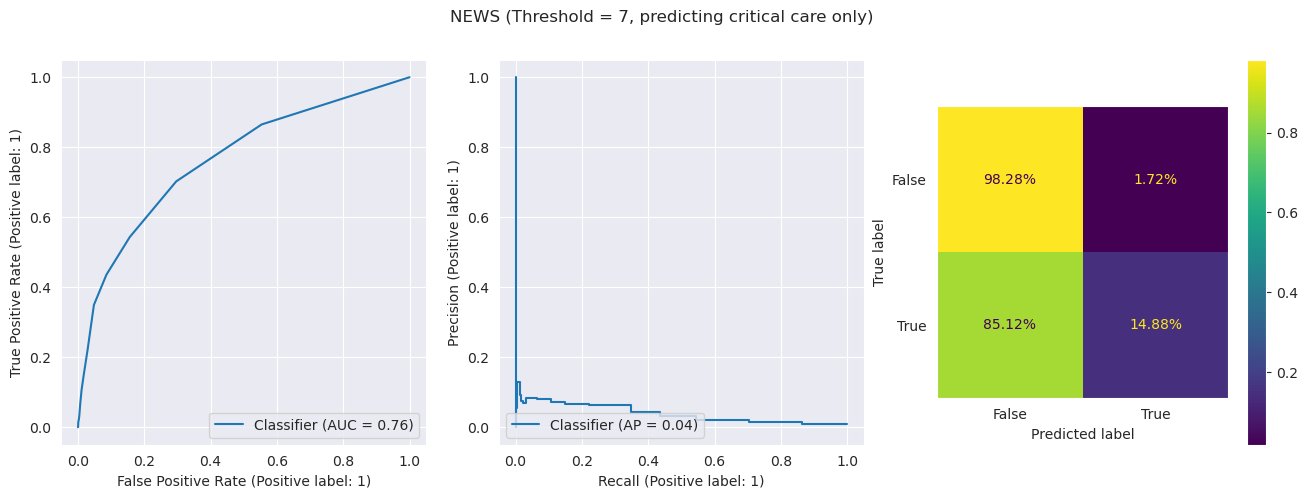

In [11]:
print("Mortality")
Notebook.MORTALITY_RESULTS["Baseline (NEWS)"] = evaluate_from_pred(
    y_test_mortality.loc[baseline_mask],
    y_pred=(sci.loc[baseline_mask].c_NEWS_score >= 7),
    y_pred_proba=(sci.loc[baseline_mask].c_NEWS_score),
    plot_title="NEWS (Threshold = 7, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/baseline_news_mortality.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS["Baseline (NEWS)"] = evaluate_from_pred(
    y_test_criticalcare.loc[baseline_mask],
    y_pred=(sci.loc[baseline_mask].c_NEWS_score >= 7),
    y_pred_proba=(sci.loc[baseline_mask].c_NEWS_score),
    plot_title="NEWS (Threshold = 7, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/baseline_news_criticalcare.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)



### Logistic Regression (NEWS only)

Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.860093   0.067301  0.657505  0.122104  0.238753  0.823776   

            AUC_CI  
Model  0.801-0.845

array([[27181,  4310],
       [  162,   311]])

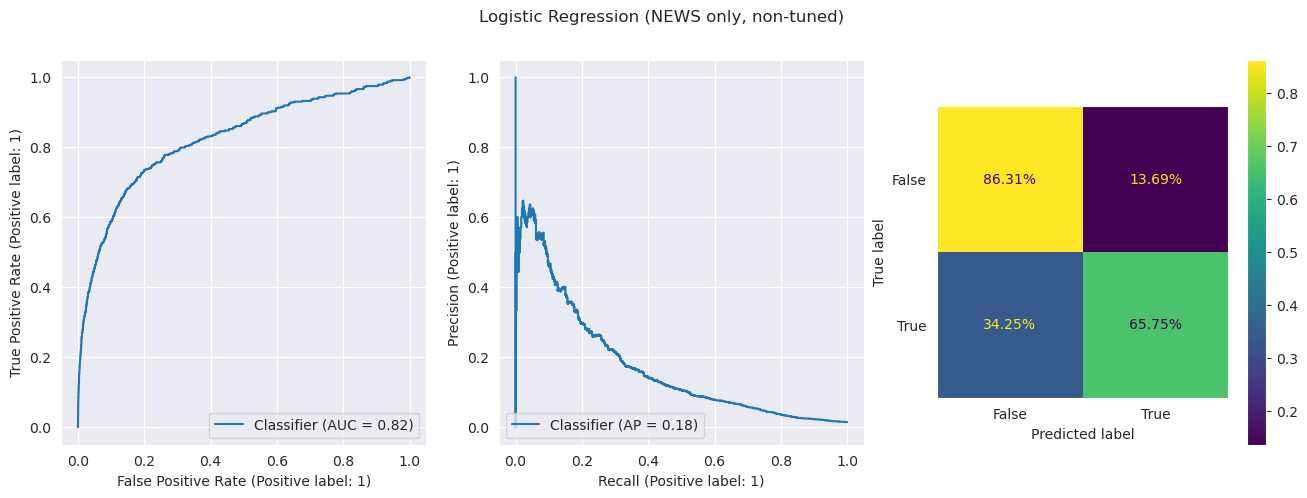

In [12]:
from sklearn.linear_model import LogisticRegression

modelkey = "Logistic Regression (NEWS only)"
model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42).fit(
    X_train_news, y_train_news
)
Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_news,
    y_test_news,
    plot_title="Logistic Regression (NEWS only, non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision   Recall  F1 Score  F2 Score       AUC       AUC_CI
Model  0.549931   0.027251  0.84778  0.052805  0.120732  0.823776  0.801-0.845

array([[17177, 14314],
       [   72,   401]])

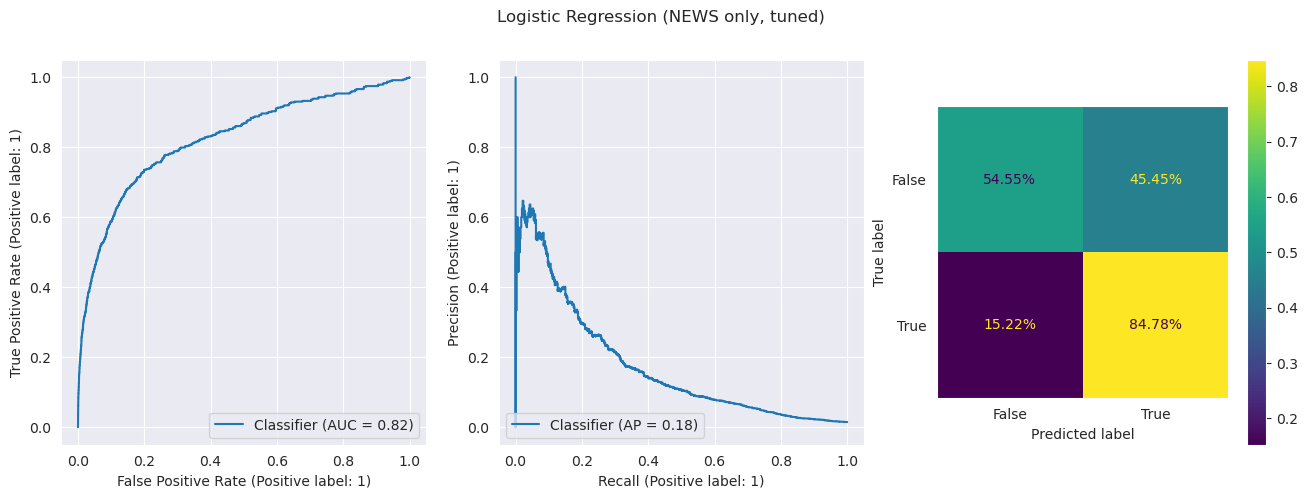

In [13]:
threshold = get_threshold(y_train_news, model.predict_proba(X_train_news)[:, 1],)

y_pred_proba = model.predict_proba(X_test_news)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_news,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (NEWS only, tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)



Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.545332   0.013456  0.925234  0.026526   0.06358  0.901883   

            AUC_CI  
Model  0.875-0.927

array([[17233, 14517],
       [   16,   198]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.545051   0.015698  0.799308  0.030792  0.072774  0.774009   

            AUC_CI  
Model  0.744-0.803

array([[17191, 14484],
       [   58,   231]])

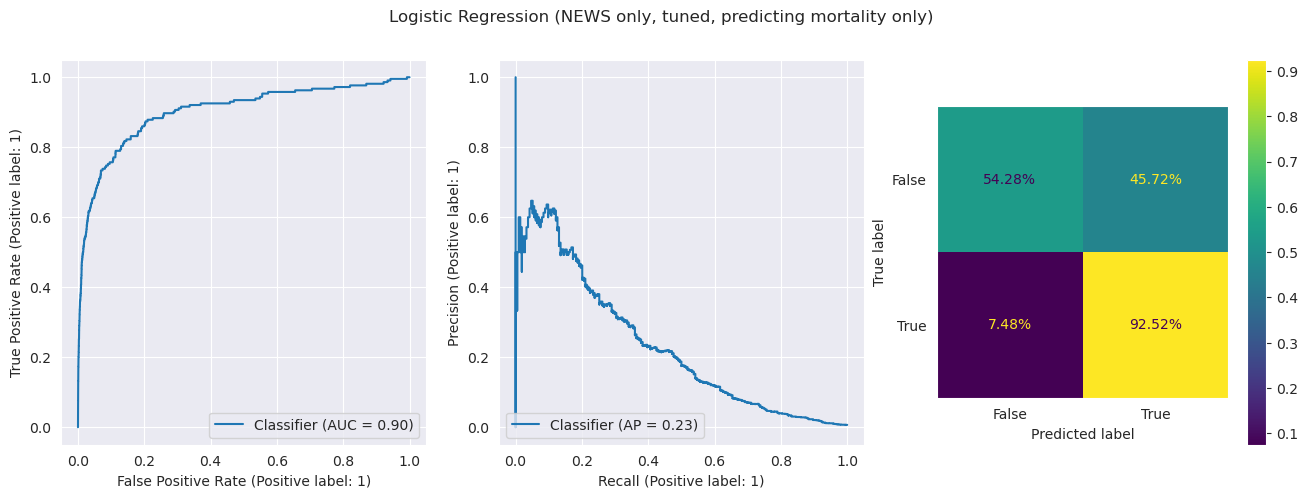

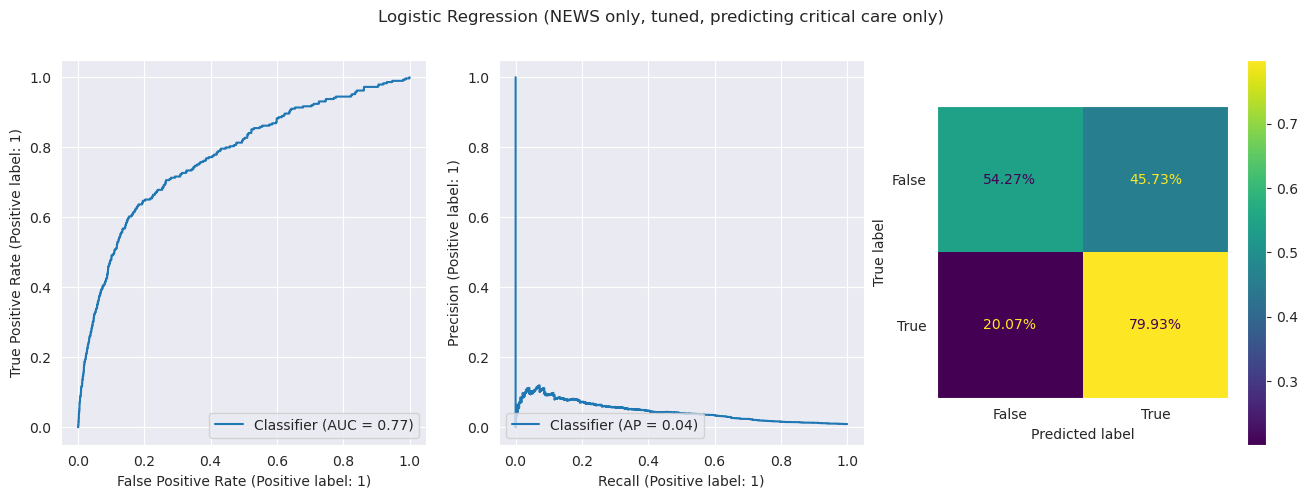

In [14]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (NEWS only, tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (NEWS only, tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

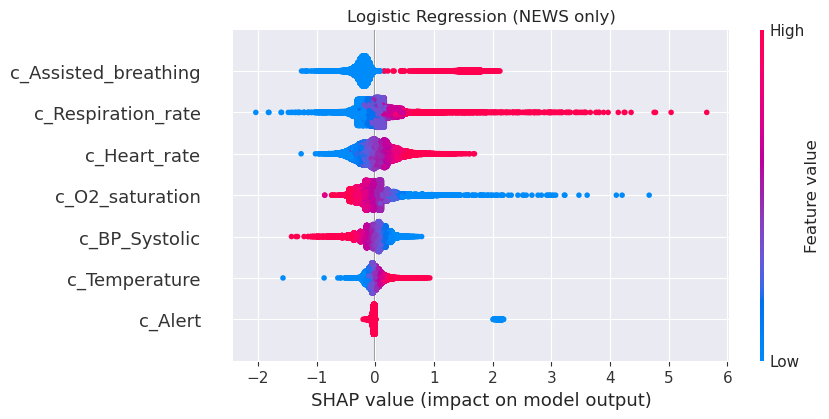

In [15]:
explainer = shap.LinearExplainer(
    model, X_train_news, feature_perturbation="correlation_dependent"
)
shap_values = explainer(X_test_news)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression (NEWS only)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression_news.png",
        bbox_inches="tight",
    )


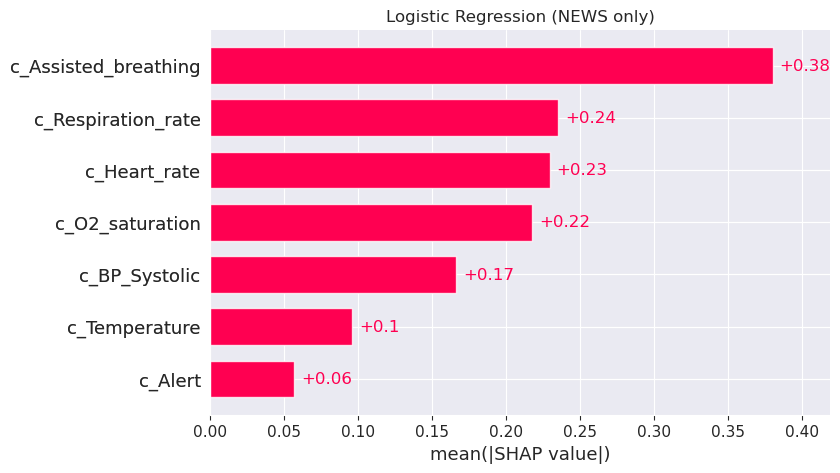

In [16]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression (NEWS only)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_logistic_regression_news.png",
        bbox_inches="tight",
    )


### Logistic Regression

In [17]:
lr_params = {
    "LR__max_iter": 10000,
    "LR__penalty": "l2",
    "LR__solver": "lbfgs",
    "LR__C": 7.87,
    "LR__class_weight": "balanced",
    "IMB__sampling_strategy": 0.2,
}

if Notebook.RUN_HYPERPARAMETERS:
    lr_params.update(
        tune_logisticregression(
            X_train,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
        )
    )


BEST PARAMETERS
{'LR__penalty': 'l2', 'LR__C': 8.829099115582656, 'LR__class_weight': 'balanced', 'IMB__sampling_strategy': 0.1392968193842939}


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.861813    0.08291  0.828753   0.15074  0.296073  0.902988   

            AUC_CI  
Model  0.886-0.920

array([[27155,  4336],
       [   81,   392]])

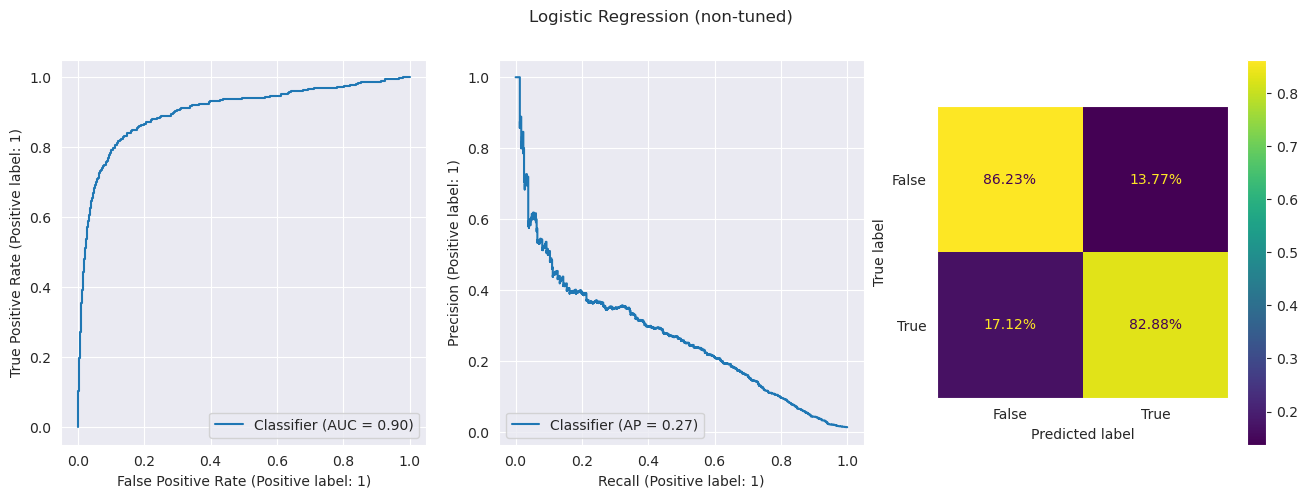

In [18]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "Logistic Regression"
model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("LR", LogisticRegression()),])
    .set_params(**lr_params)
    .fit(X_train, y_train)
)

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test,
    y_test,
    plot_title="Logistic Regression (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

Notebook.MODELS[modelkey] = model


X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.829965   0.069719  0.849894  0.128867  0.262471  0.902988   

            AUC_CI  
Model  0.886-0.920

array([[26127,  5364],
       [   71,   402]])

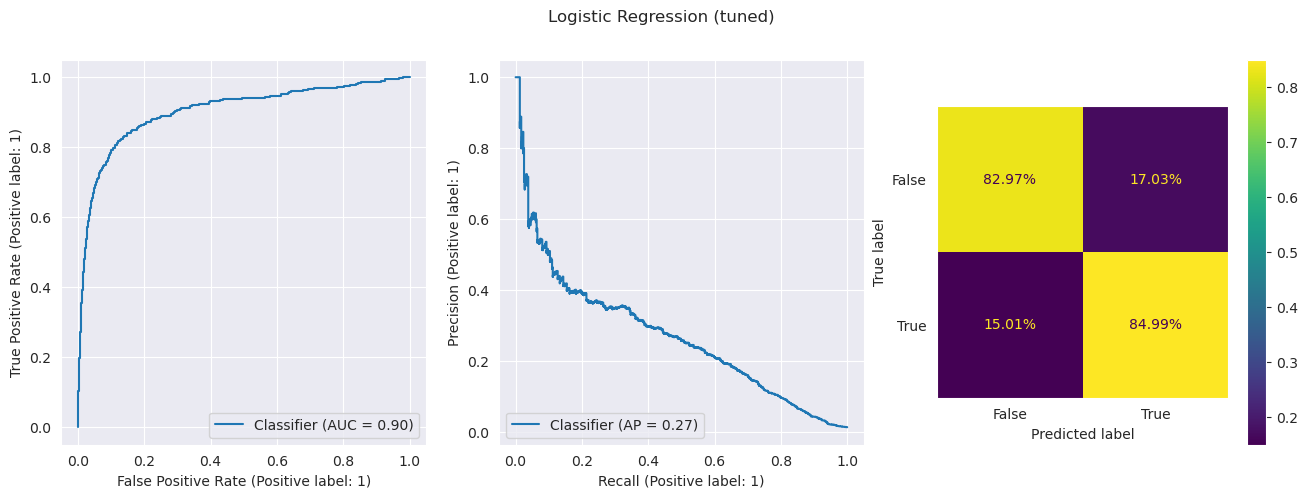

In [19]:
threshold = get_threshold(y_train, model.predict_proba(X_train)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.824115   0.031044  0.836449  0.059866  0.135156  0.900876   

            AUC_CI  
Model  0.875-0.924

array([[26163,  5587],
       [   35,   179]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.826273   0.043531  0.868512  0.082907  0.181306  0.903406   

            AUC_CI  
Model  0.880-0.925

array([[26160,  5515],
       [   38,   251]])

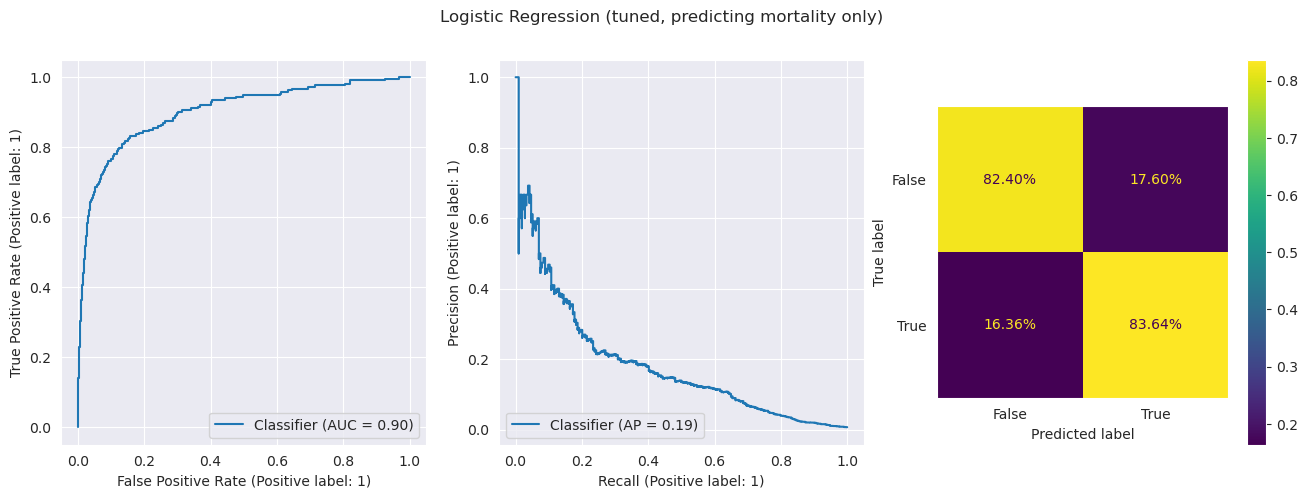

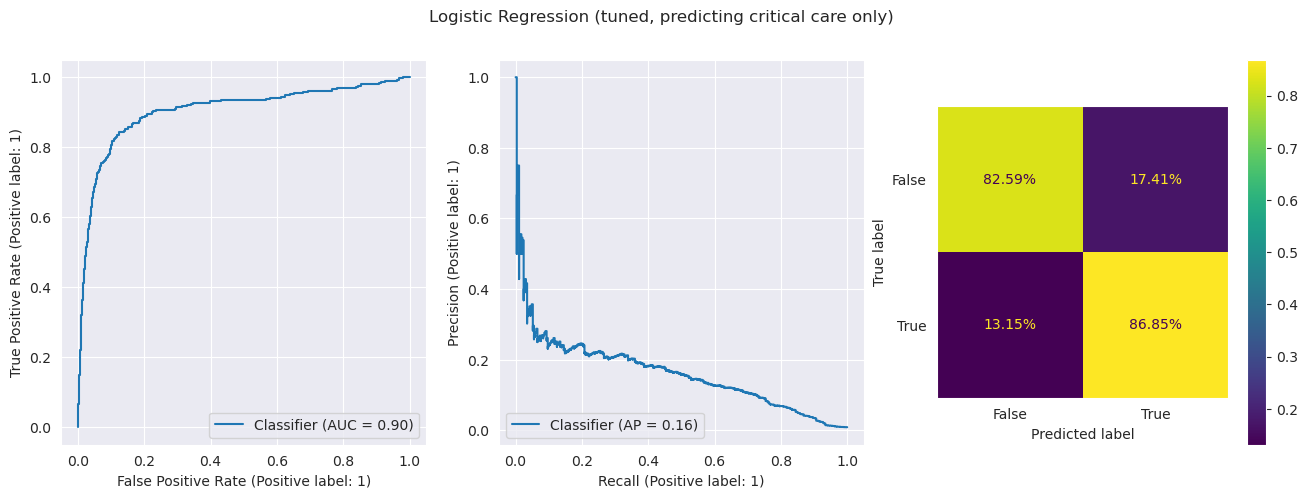

In [20]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

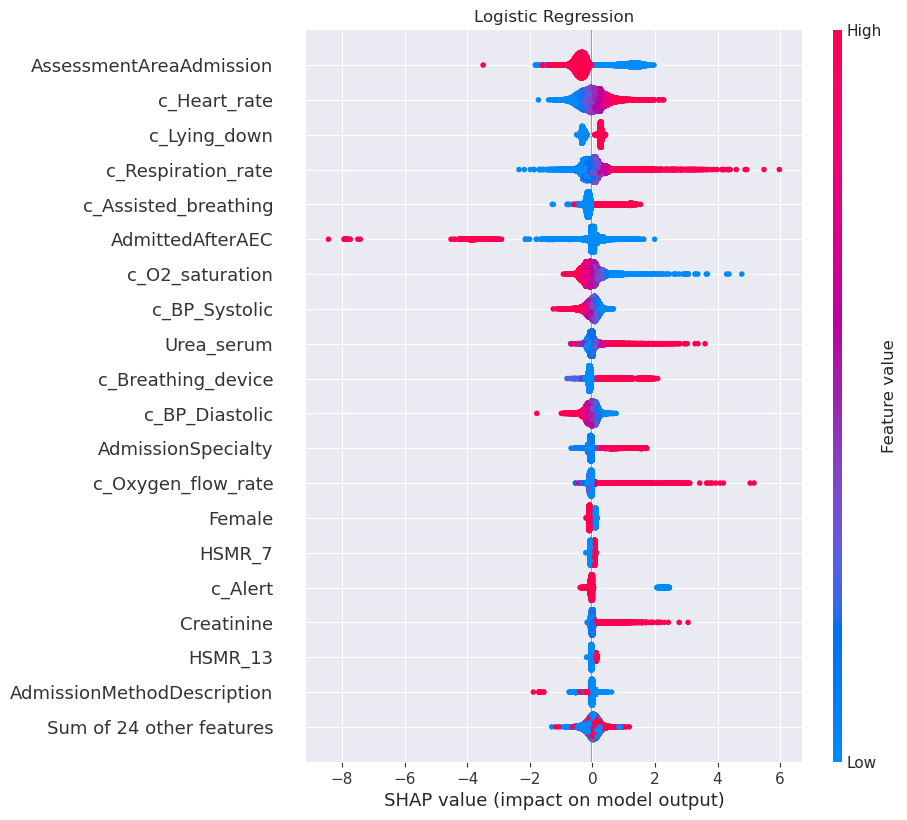

In [21]:
explainer = shap.LinearExplainer(
    model["LR"], X_train, feature_perturbation="correlation_dependent"
)
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression.png", bbox_inches="tight"
    )


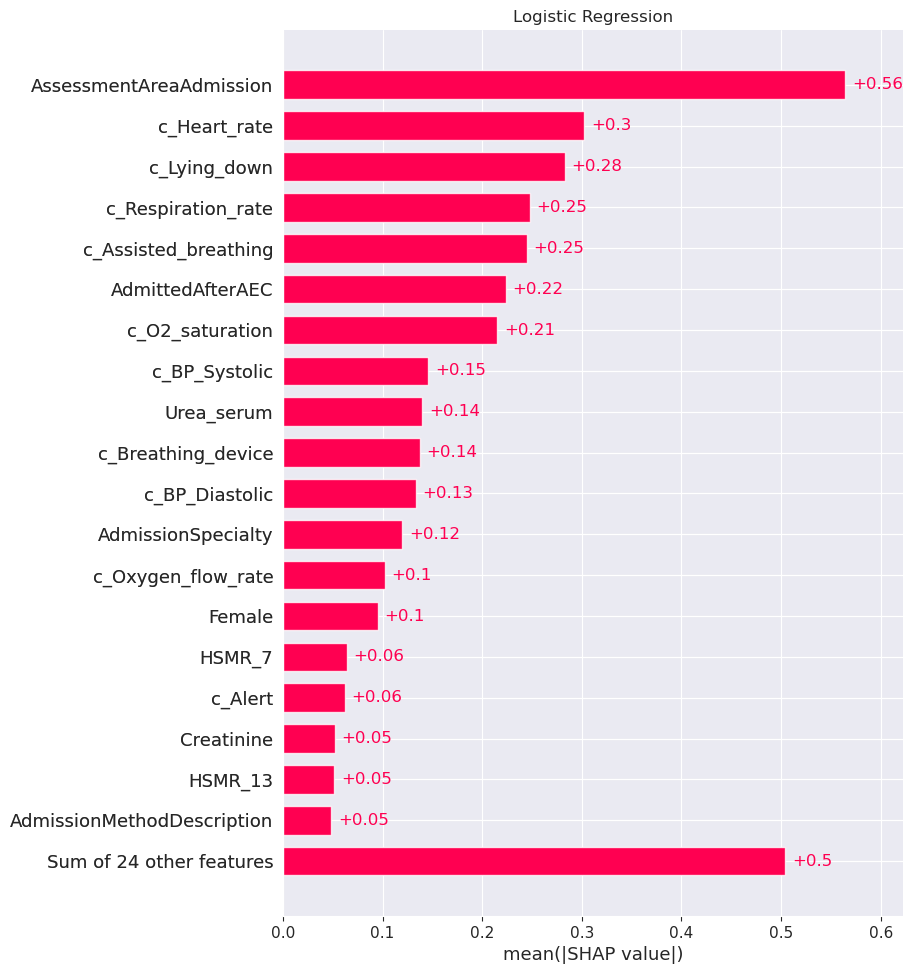

In [22]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_logistic_regression.png", bbox_inches="tight"
    )


### Random Forest

In [23]:
rf_params = {
    "RF__n_estimators": 250,
    "RF__max_features": 0.56,
    "RF__min_samples_split": 8,
    "RF__min_samples_leaf": 3,
    "RF__max_samples": 0.75,
    "RF__class_weight": "balanced",
    "IMB__sampling_strategy": 0.14,
}

if Notebook.RUN_HYPERPARAMETERS:
    rf_params.update(
        tune_randomforest(
            X_train,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
        )
    )



BEST PARAMETERS
{'RF__n_estimators': 100, 'RF__max_features': 0.3402271140828651, 'RF__min_samples_split': 10, 'RF__min_samples_leaf': 5, 'RF__max_samples': 0.7041521643348305, 'RF__class_weight': 'balanced', 'IMB__sampling_strategy': 0.1743237578944012}


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.951414   0.196288  0.737844  0.310084  0.475477  0.932882   

            AUC_CI  
Model  0.920-0.945

array([[30062,  1429],
       [  124,   349]])

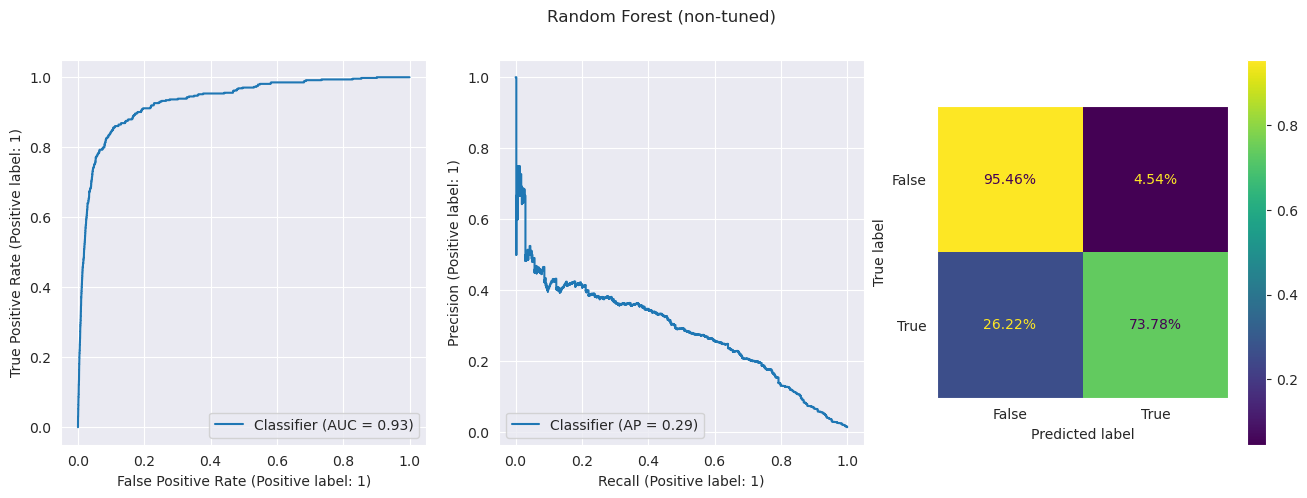

In [24]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "Random Forest"
model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("RF", RandomForestClassifier())])
    .set_params(**rf_params)
    .fit(X_train.to_numpy(), y_train)
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test.to_numpy(),
    y_test,
    plot_title="Random Forest (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)



Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.940464   0.169288  0.773784  0.277799  0.451406  0.932882   

            AUC_CI  
Model  0.920-0.945

array([[29695,  1796],
       [  107,   366]])

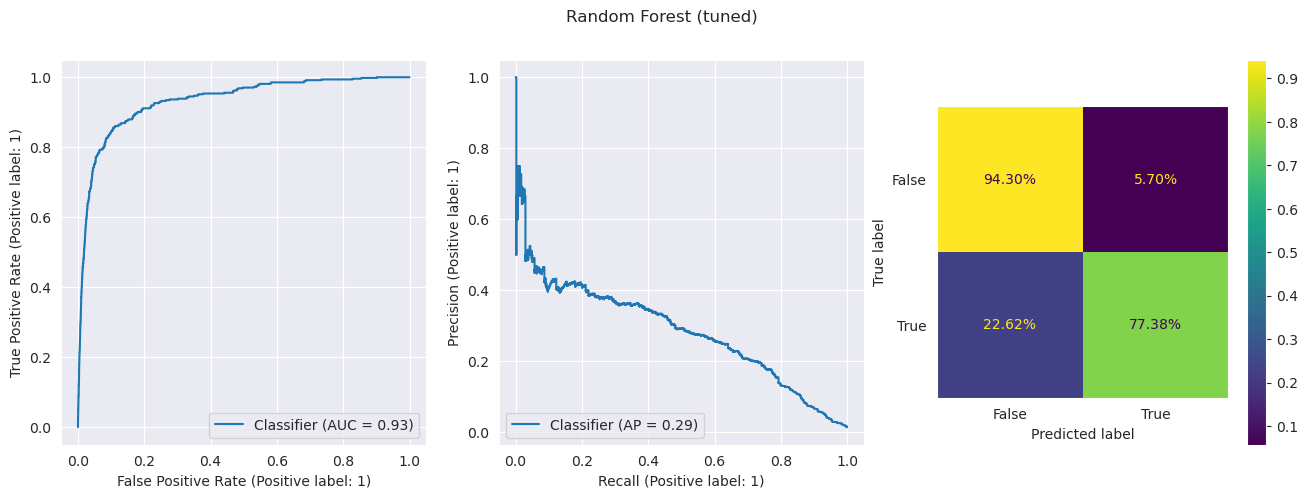

In [25]:
threshold = get_threshold(y_train, model.predict_proba(X_train.to_numpy())[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test.to_numpy())[:, 1]
y_pred = np.where(y_pred_proba > 1 - threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model   0.93549   0.072618  0.733645  0.132155  0.260106  0.921623   

            AUC_CI  
Model  0.901-0.940

array([[29745,  2005],
       [   57,   157]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.937899   0.107771  0.806228  0.190126  0.351115  0.940371   

            AUC_CI  
Model  0.926-0.954

array([[29746,  1929],
       [   56,   233]])

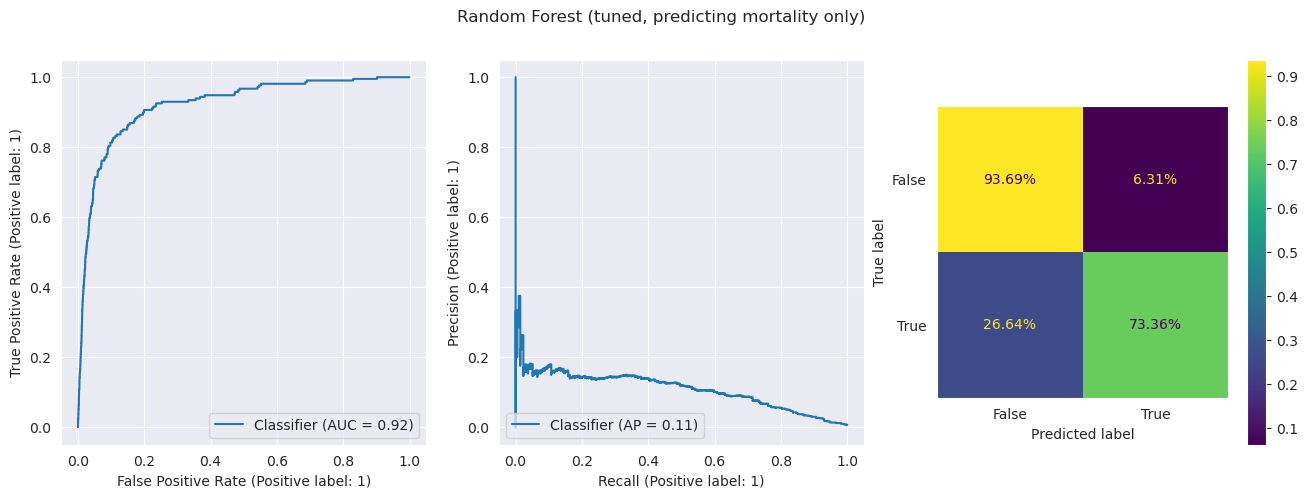

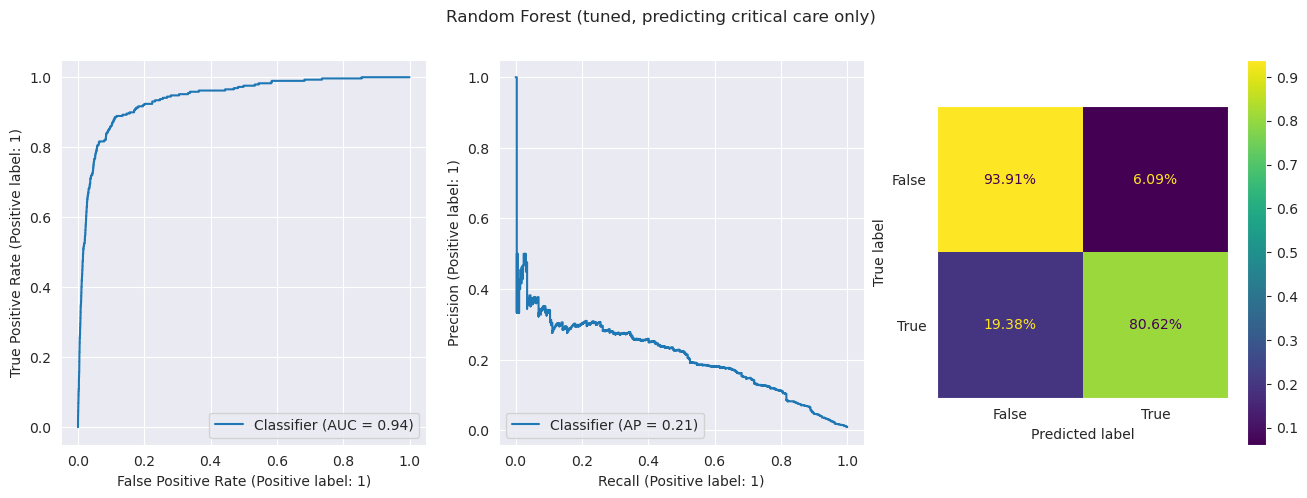

In [26]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


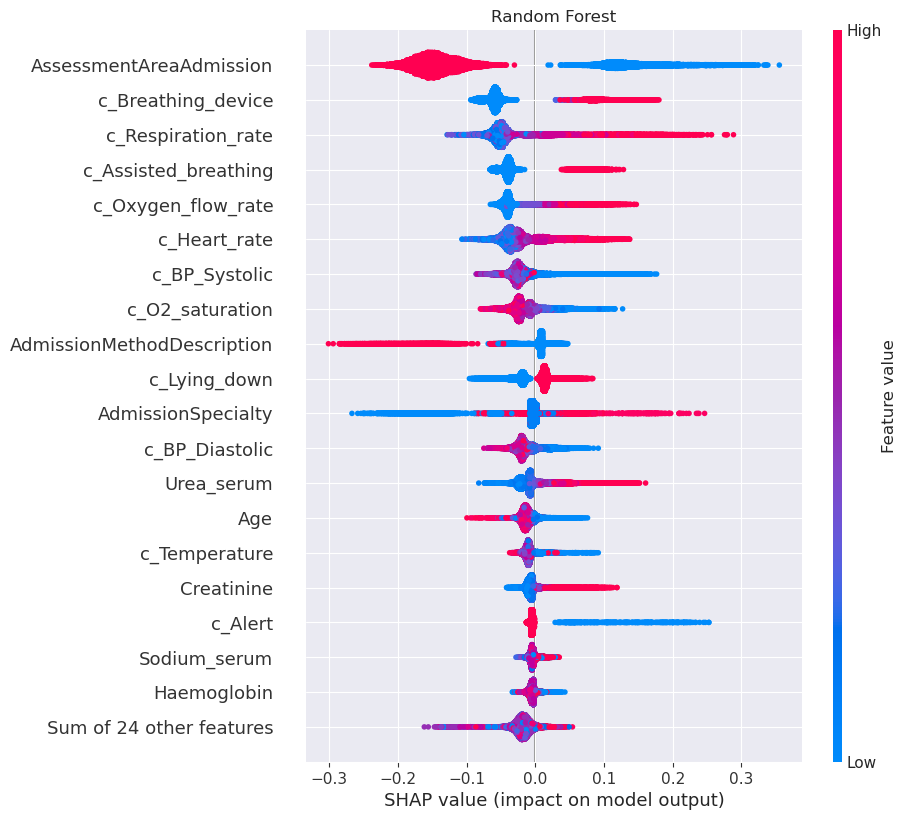

In [27]:
explainer = shap.TreeExplainer(model["RF"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Random Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_random_forest.png", bbox_inches="tight"
    )


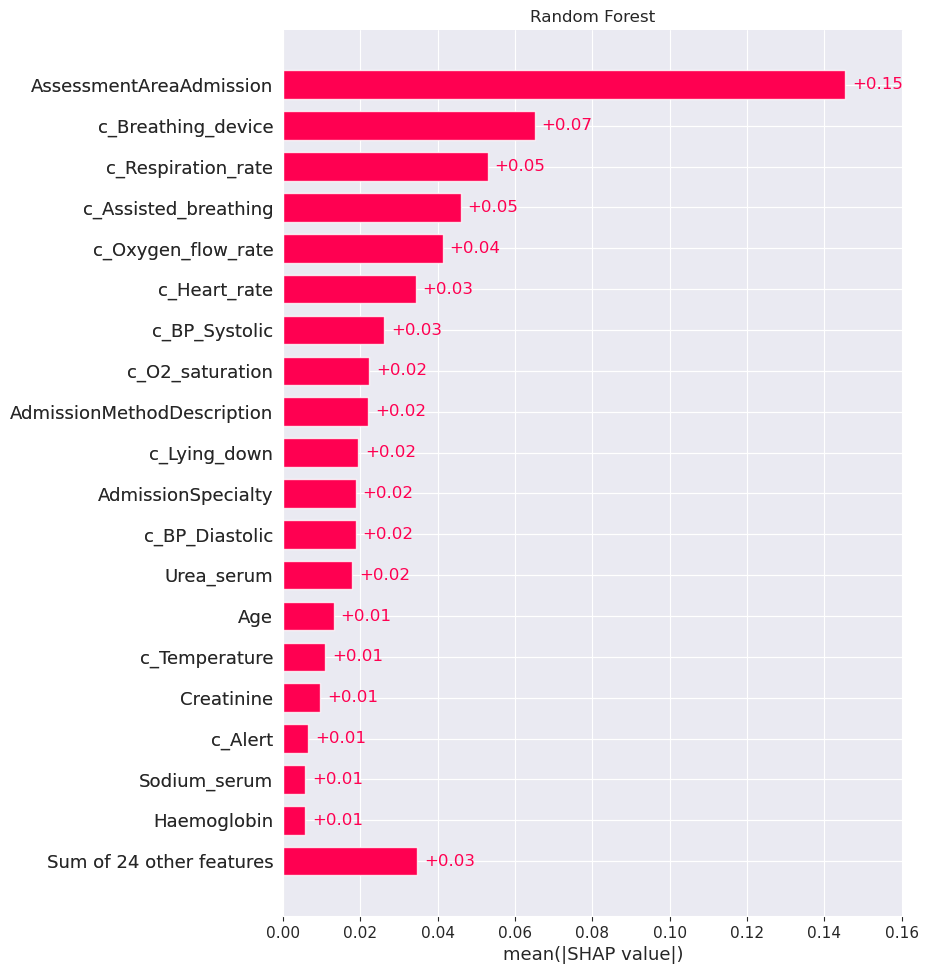

In [28]:
fig = shap.plots.bar(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Random Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_random_forest.png", bbox_inches="tight")


### XGBoost

In [29]:
xgboost_params = {
    "XGB__verbosity": 0,
    "XGB__n_jobs": 1,
    "XGB__missing": -1,
    "XGB__objective": "binary:logistic",
    "XGB__enable_categorical": True,
    "XGB__tree_method": "hist",
    "XGB__missing": -1,
    "XGB__booster": "gbtree",
    "XGB__lambda": 7e-2,
    "XGB__alpha": 7e-05,
    "XGB__subsample": 0.42,
    "XGB__colsample_bytree": 0.87,
    "XGB__scale_pos_weight": 14,
    "XGB__max_depth": 7,
    "XGB__min_child_weight": 10,
    "XGB__eta": 0.034,
    "XGB__gamma": 4e-08,
    "XGB__grow_policy": "lossguide",
    "IMB__sampling_strategy": 0.1,
}


if Notebook.RUN_HYPERPARAMETERS:
    xgboost_params.update(
        tune_xgboost(
            X_train_lgbm,
            y_train_lgbm,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
        )
    )



BEST PARAMETERS
{'XGB__tree_method': 'hist', 'XGB__lambda': 9.255273660082063e-08, 'XGB__alpha': 3.2155388019627186e-06, 'XGB__subsample': 0.6725163138276885, 'XGB__colsample_bytree': 0.5187528367393992, 'XGB__scale_pos_weight': 8, 'IMB__sampling_strategy': 0.14569998426166234, 'XGB__max_depth': 7, 'XGB__min_child_weight': 4, 'XGB__eta': 0.04445778653449962, 'XGB__gamma': 0.0006620992515555966, 'XGB__grow_policy': 'lossguide'}


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.927137    0.14526  0.803383  0.246034  0.421473  0.932242   

            AUC_CI  
Model  0.918-0.945

array([[29255,  2236],
       [   93,   380]])

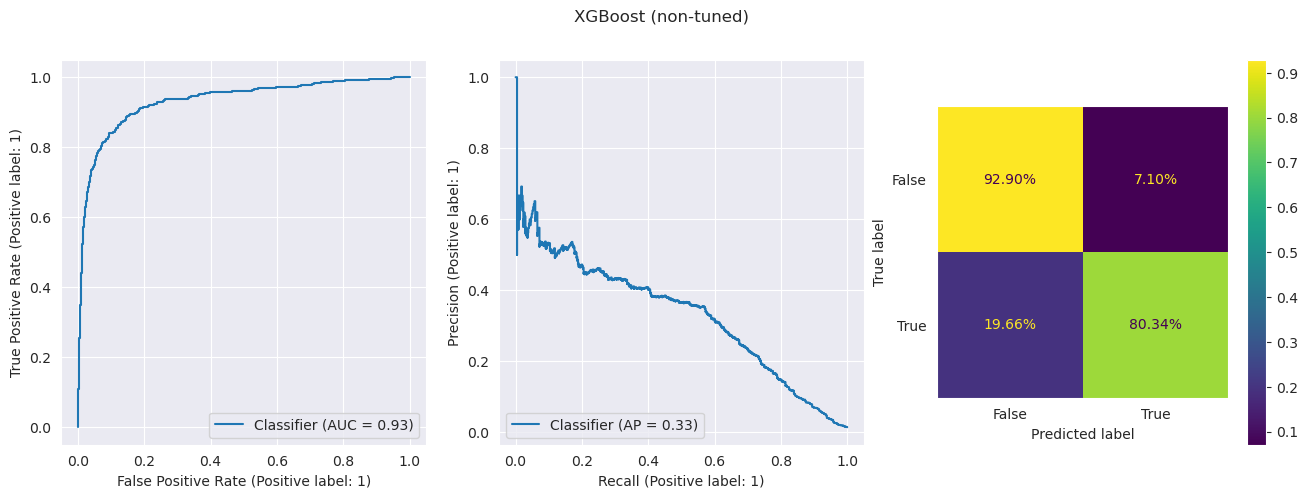

In [30]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "XGBoost"
model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("XGB", XGBClassifier()),])
    .set_params(**xgboost_params)
    .fit(X_train_lgbm, y_train_lgbm)
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_lgbm,
    y_test_lgbm,
    "XGBoost (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_xgboost.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.847735   0.080245  0.887949  0.147188  0.294695  0.932242   

            AUC_CI  
Model  0.918-0.945

array([[26677,  4814],
       [   53,   420]])

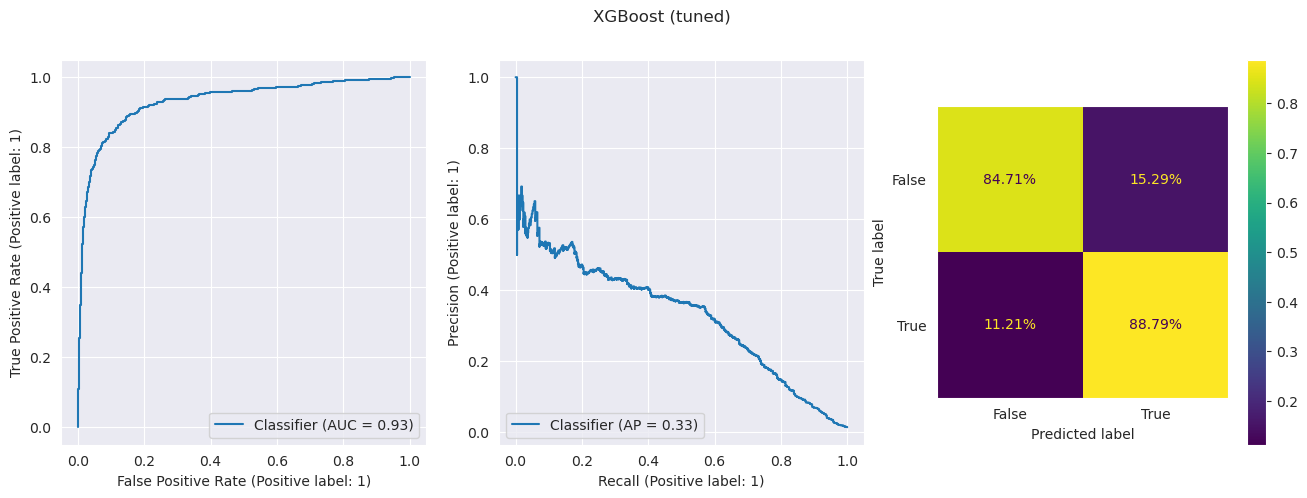

In [31]:
threshold = get_threshold(y_train_lgbm, model.predict_proba(X_train_lgbm)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test_lgbm)[:, 1]
y_pred = np.where(y_pred_proba > 1 - threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_lgbm,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_xgboost.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score      AUC       AUC_CI
Model  0.841321   0.035919  0.878505  0.069016  0.154351  0.92302  0.900-0.943

array([[26704,  5046],
       [   26,   188]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.843605   0.050057  0.906574  0.094876  0.205008  0.939044   

            AUC_CI  
Model  0.923-0.954

array([[26703,  4972],
       [   27,   262]])

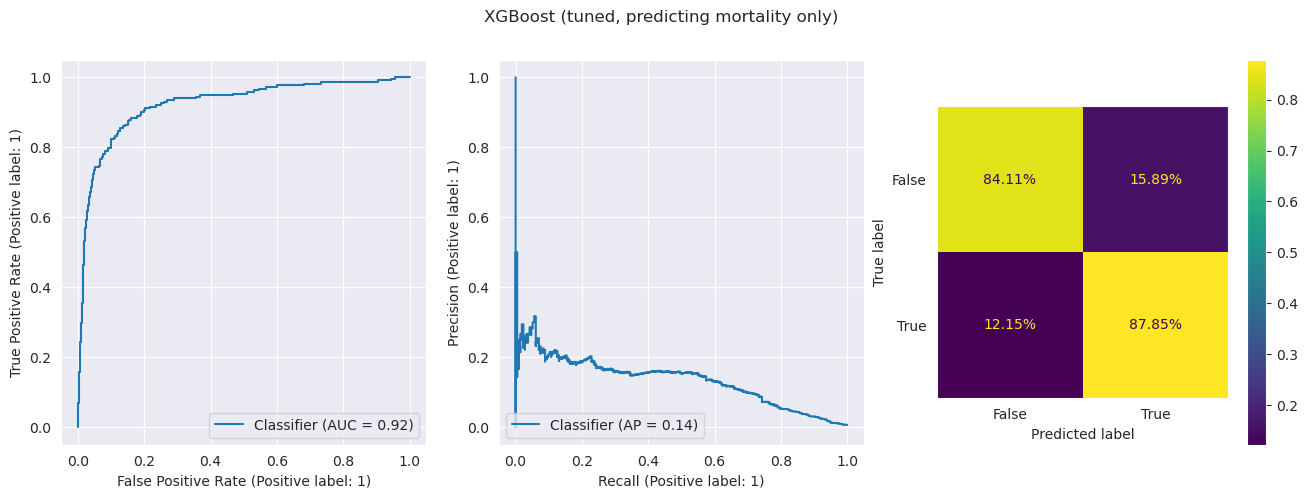

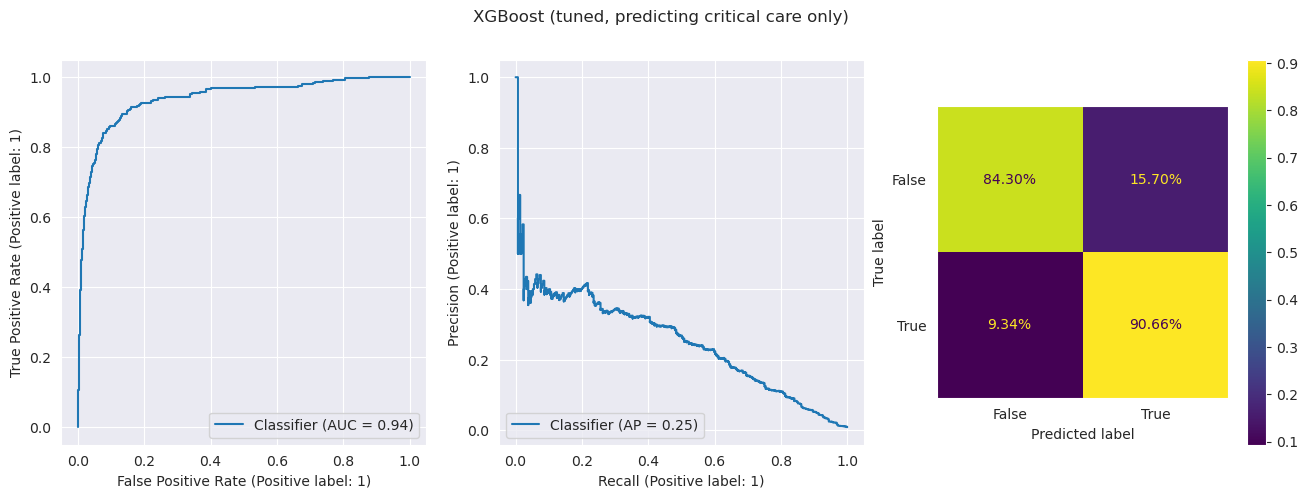

In [32]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_xgboost.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_xgboost.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


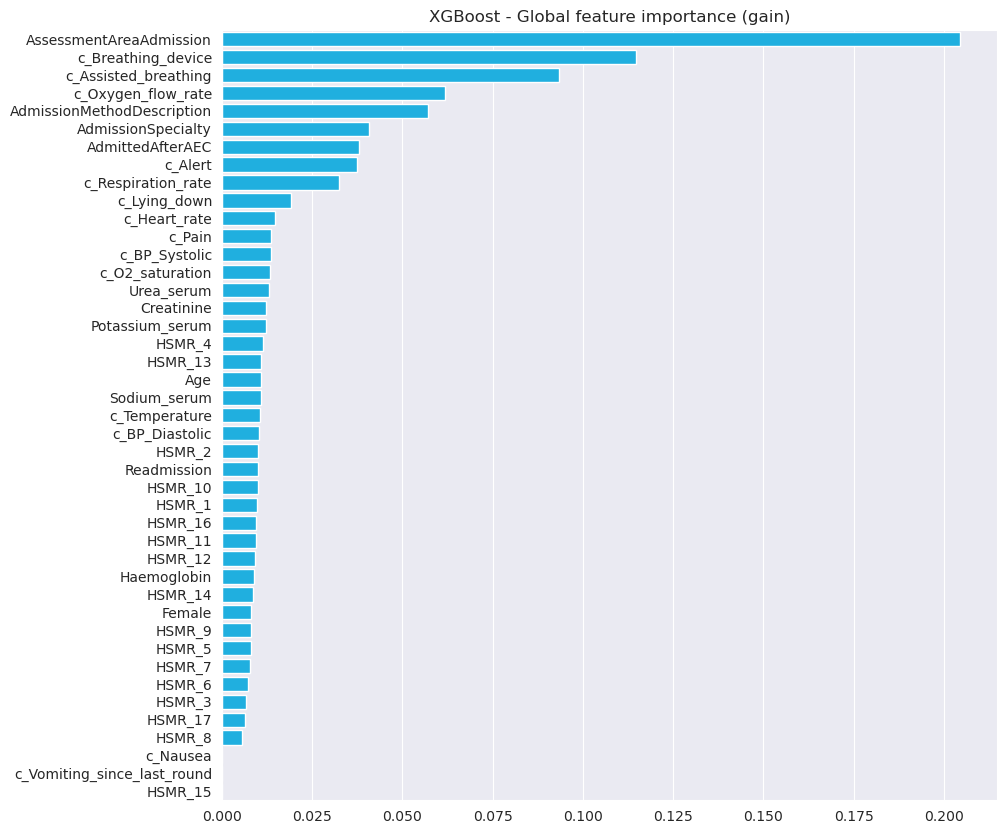

In [33]:
sorted_idx = model["XGB"].feature_importances_.argsort()[::-1]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.barplot(
    x=model["XGB"].feature_importances_[sorted_idx],
    y=X_train.columns[sorted_idx],
    color="deepskyblue",
    ax=ax
)
ax.set_title("XGBoost - Global feature importance (gain)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/global_weights_xgboost.png", bbox_inches="tight")



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


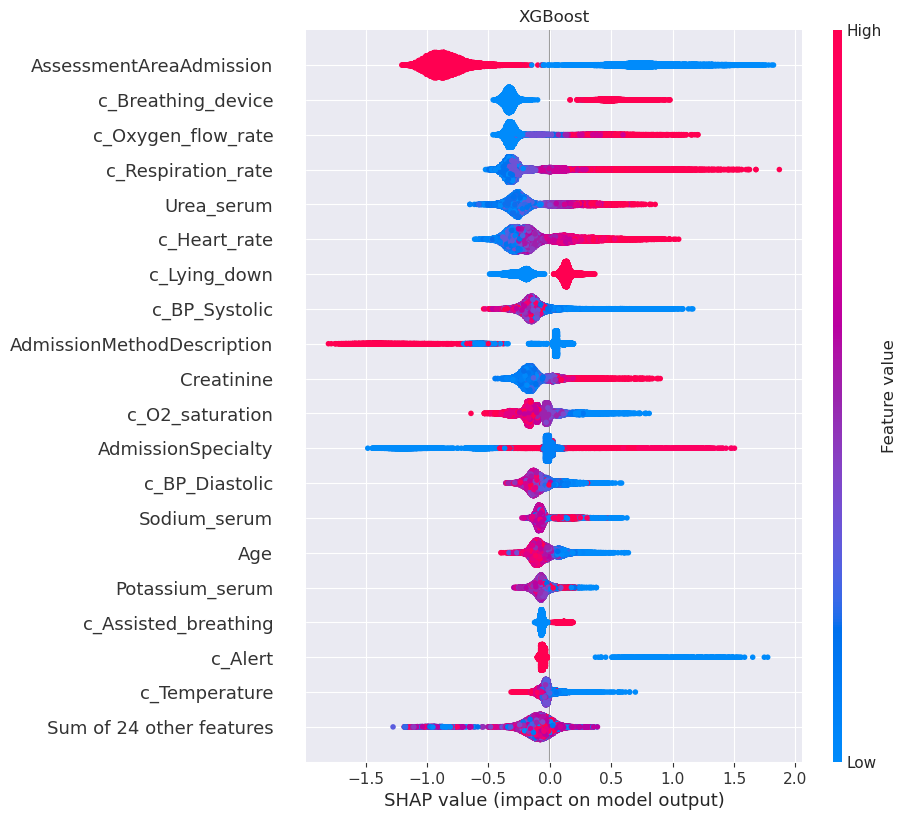

In [34]:
explainer = shap.TreeExplainer(model["XGB"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("XGBoost")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_xgboost.png", bbox_inches="tight")


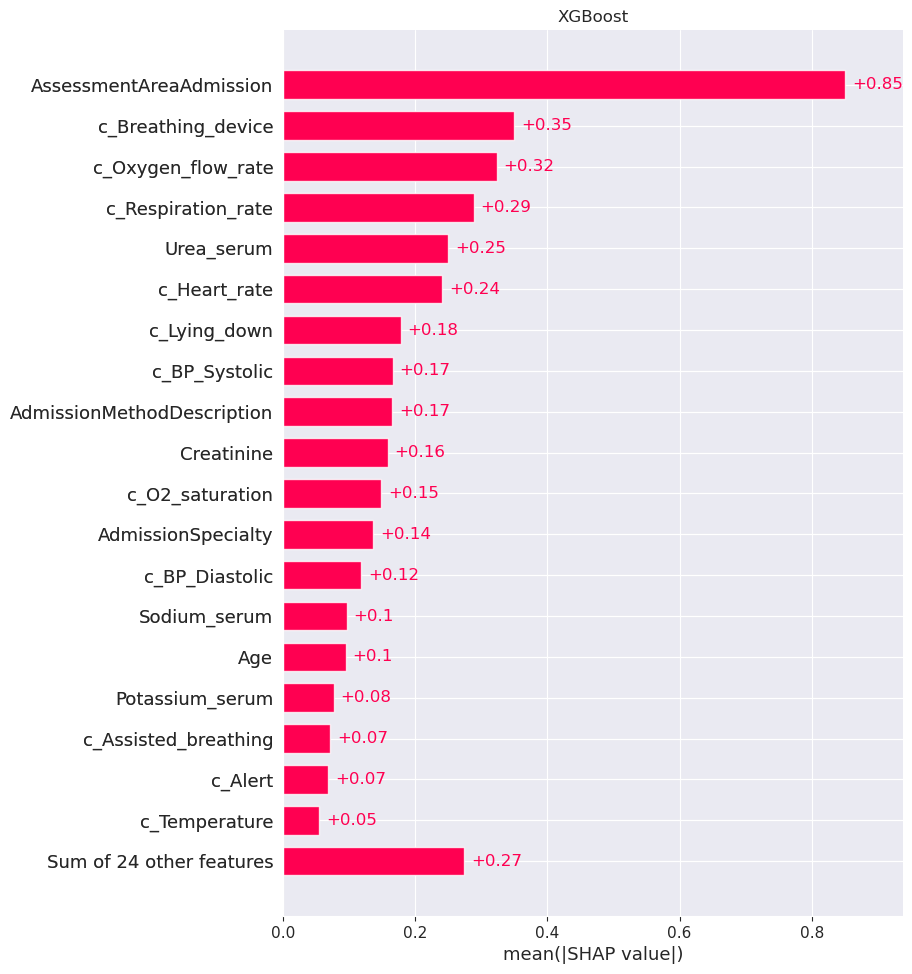

In [35]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("XGBoost")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_xgboost.png", bbox_inches="tight")


### LightGBM

In [1]:
lgbm_params = {
    "LGBM__objective": "binary",
    "LGBM__metrics": ["l2", "auc"],
    "LGBM__boosting_type": "gbdt",
    "LGBM__is_unbalance": True,
    "LGBM__n_jobs": 1,
    "LGBM__feature_pre_filter": False,
    "LGBM__lambda_l1": 0.15,
    "LGBM__lambda_l2": 3.2,
    "LGBM__num_leaves": 225,
    "LGBM__feature_fraction": 0.8,
    "LGBM__bagging_fraction": 0.8,
    "LGBM__bagging_freq": 7,
    "LGBM__min_child_samples": 45,
    "IMB__sampling_strategy": 0.1,
}

if Notebook.RUN_HYPERPARAMETERS:
    lgbm_params.update(
        tune_lgbm(
            X_train_lgbm,
            y_train_lgbm,
            categorical_cols_idx,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
        )
    )


BEST PARAMETERS
{'LGBM__lambda_l1': 0.1414351542353416, 'LGBM__lambda_l2': 0.0026009557480055154, 'LGBM__num_leaves': 8, 'LGBM__feature_fraction': 0.5583147026063064, 'LGBM__bagging_fraction': 0.9291640339471489, 'LGBM__bagging_freq': 7, 'LGBM__min_child_samples': 76, 'IMB__sampling_strategy': 0.2023748081425376}


[LightGBM] [Warning] feature_fraction is set=0.5583147026063064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5583147026063064
[LightGBM] [Warning] lambda_l1 is set=0.1414351542353416, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1414351542353416
[LightGBM] [Warning] bagging_fraction is set=0.9291640339471489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9291640339471489
[LightGBM] [Warning] lambda_l2 is set=0.0026009557480055154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0026009557480055154
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.897885   0.111822  0.849894   0.19764   0.36632  0.934812   

            AUC_CI  
Model  0.922-0.947

array([[28298,  3193],
       [   71,   402]])

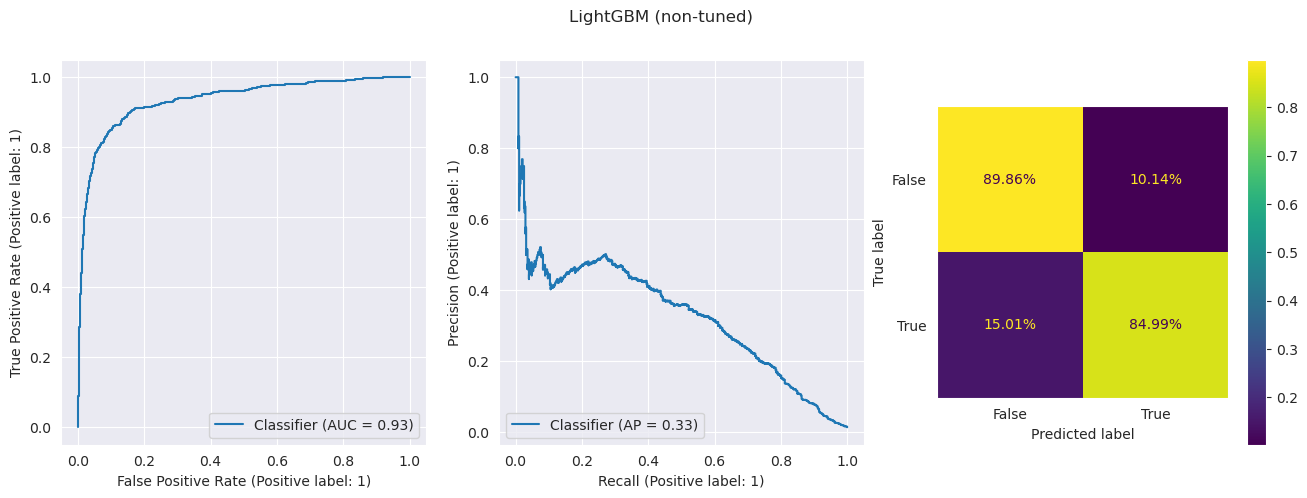

In [37]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "LightGBM"

model = (
    ImbPipeline(steps=[("IMB", RandomUnderSampler()), ("LGBM", LGBMClassifier()),])
    .set_params(**lgbm_params)
    .fit(
        X_train_lgbm,
        y_train_lgbm,
        LGBM__categorical_feature=categorical_cols_idx,
        LGBM__feature_name=list(X_train.columns),
    )
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_lgbm,
    y_test_lgbm,
    plot_title="LightGBM (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_lightgbm.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.895445   0.109447  0.849894  0.193922  0.361186  0.934812   

            AUC_CI  
Model  0.922-0.947

array([[28220,  3271],
       [   71,   402]])

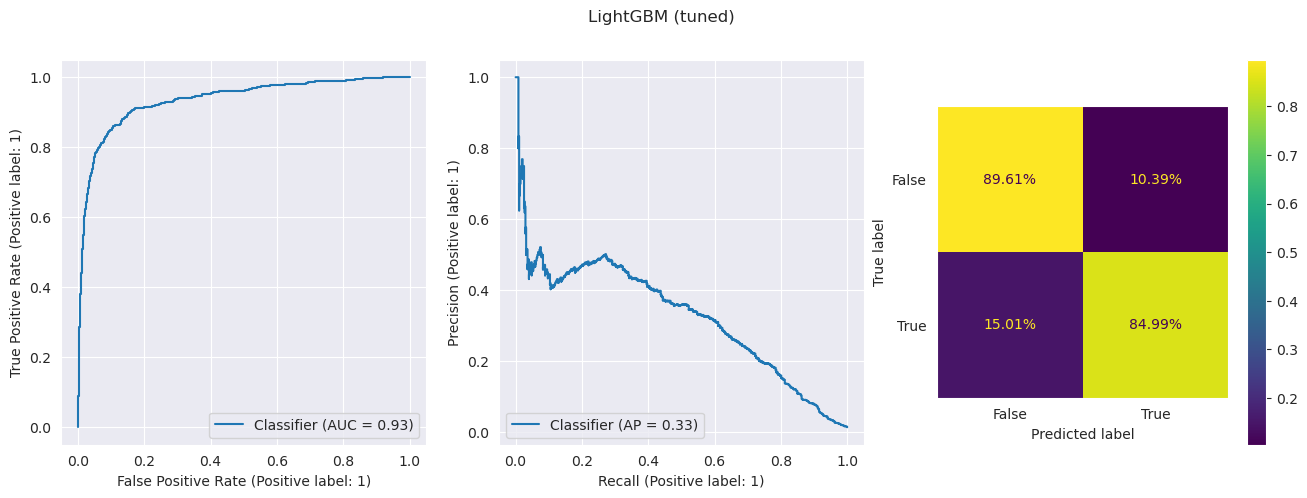

In [38]:
threshold = get_threshold(y_test_lgbm, model.predict_proba(X_test_lgbm)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test_lgbm)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_lgbm,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_lightgbm.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.889532   0.048462  0.831776  0.091587  0.196511  0.929449   

            AUC_CI  
Model  0.910-0.947

array([[28255,  3495],
       [   36,   178]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.891816   0.068609  0.871972  0.127208  0.260924  0.938246   

            AUC_CI  
Model  0.921-0.954

array([[28254,  3421],
       [   37,   252]])

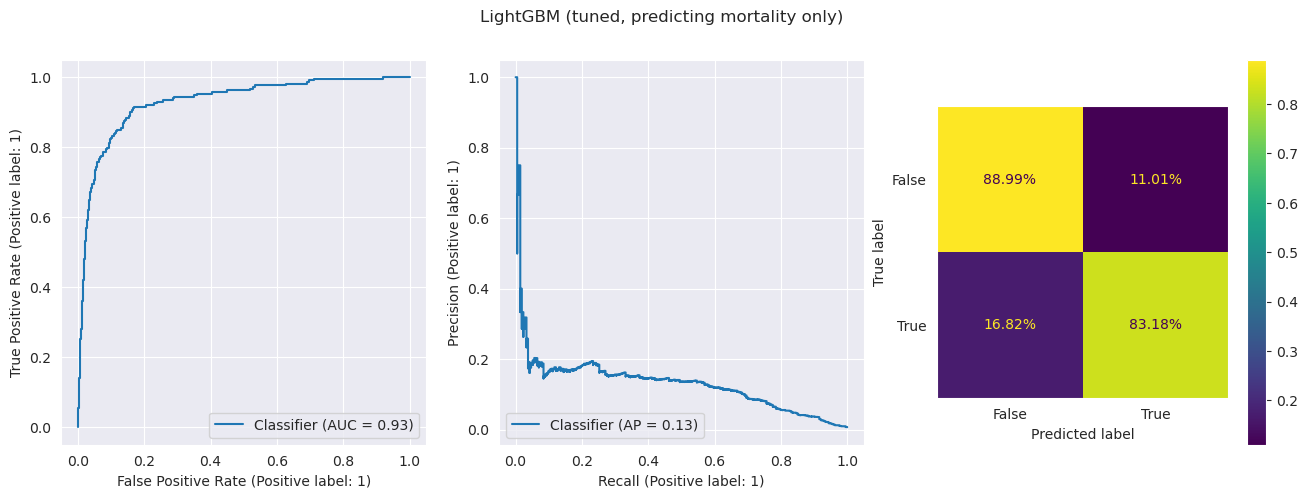

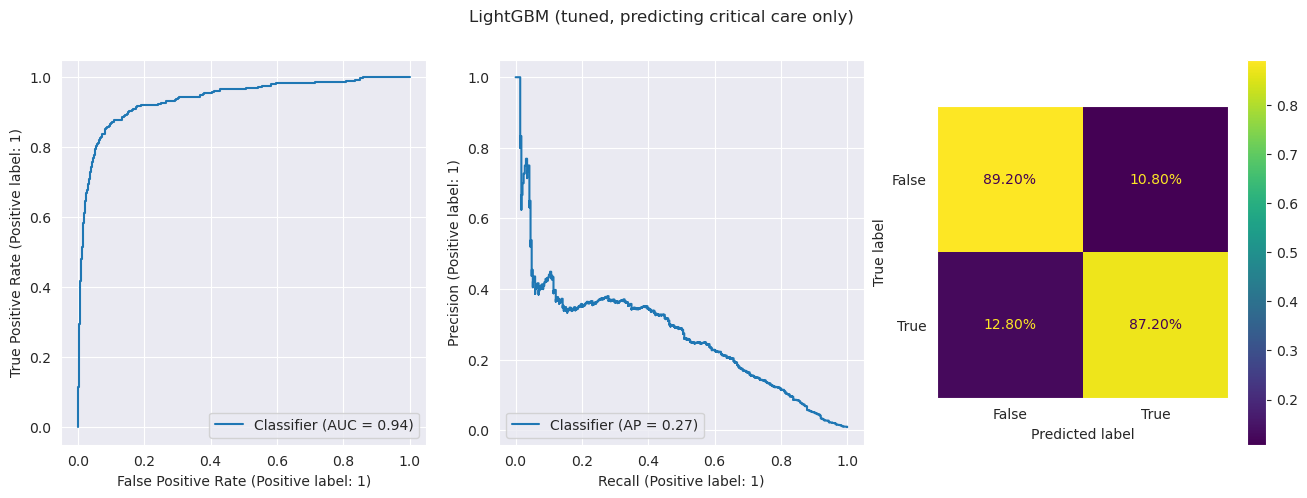

In [39]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_lightgbm.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_lightgbm.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


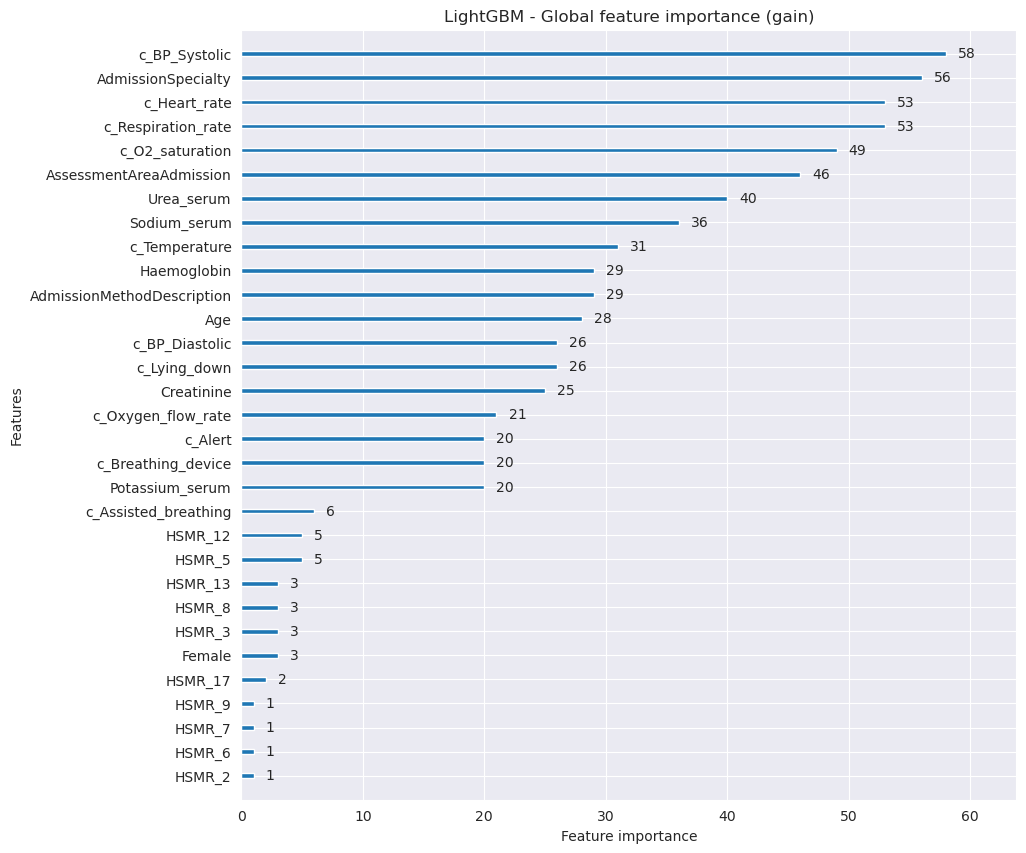

In [40]:
import lightgbm as lgb

fig = lgb.plot_importance(model["LGBM"], figsize=(10, 10))
fig.set_title("LightGBM - Global feature importance (gain)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/global_weights_lightgbm.png", bbox_inches="tight"
    )


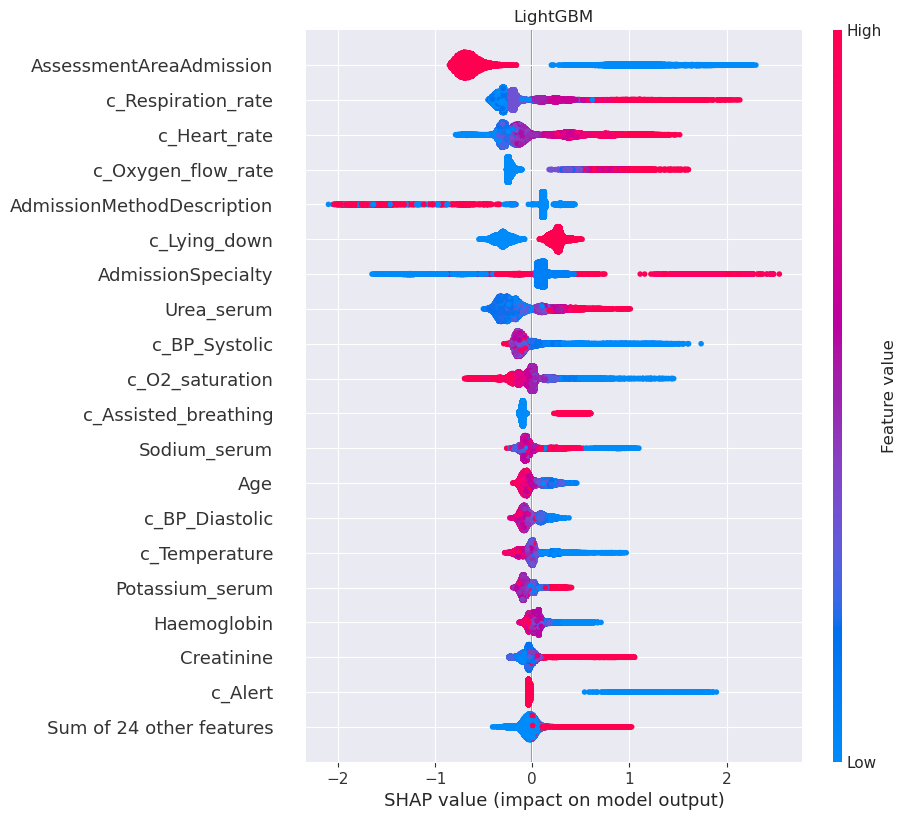

In [41]:
explainer = shap.TreeExplainer(model["LGBM"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")
if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_lightgbm.png", bbox_inches="tight")


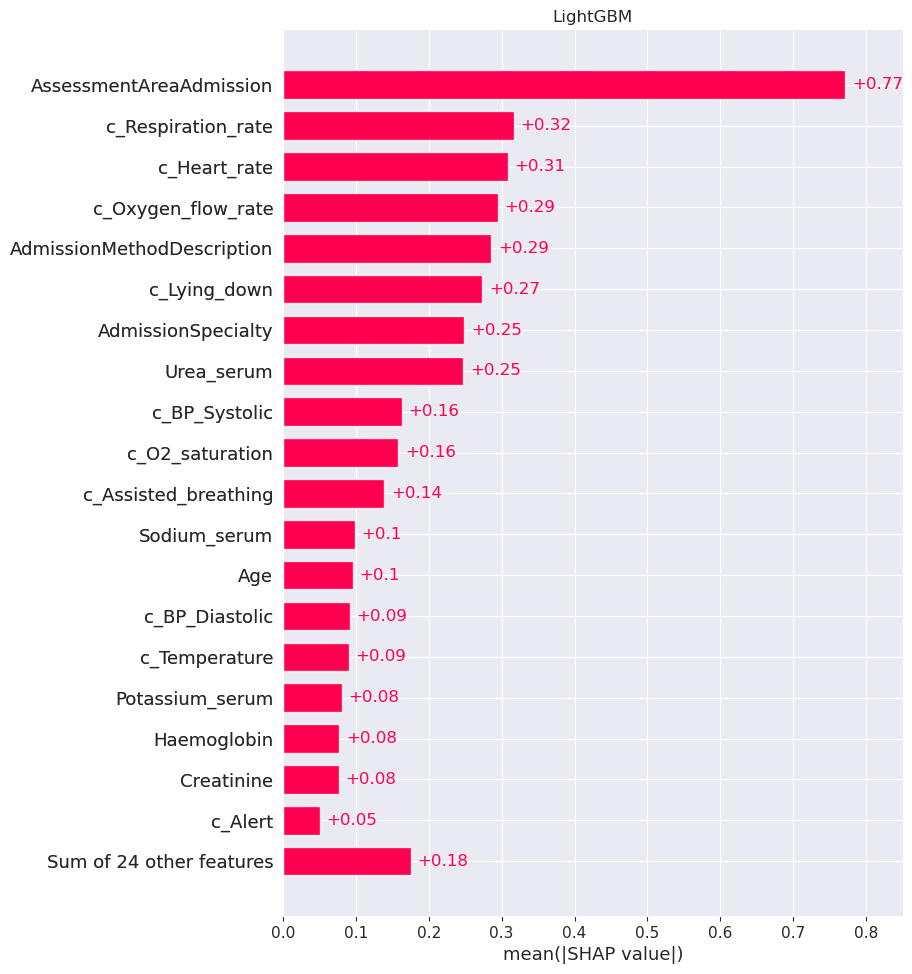

In [42]:
fig = shap.plots.bar(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_lightgbm.png", bbox_inches="tight")


### Isolation Forest

In [43]:
if_params = {
    "n_estimators": 140,
    "max_samples": 0.465,
    "contamination": 0.0213,
    "max_features": 0.69,
    "bootstrap": False,
}

if Notebook.RUN_HYPERPARAMETERS:
    if_params = tune_isolationforest(
        X_train_if,
        y_train_if,
        timeout=Notebook.HYPERPARAMETER_TIMEOUT,
        n_jobs=Notebook.HYPERPARAMETER_NJOBS,
    )



BEST PARAMETERS
{'n_estimators': 131, 'max_samples': 0.2714889660476212, 'contamination': 0.0615529697773157, 'max_features': 0.13992826836556155, 'bootstrap': False}


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.904017   0.091339  0.613108  0.158991  0.286165  0.849271   

            AUC_CI  
Model  0.831-0.868

array([[28606,  2885],
       [  183,   290]])

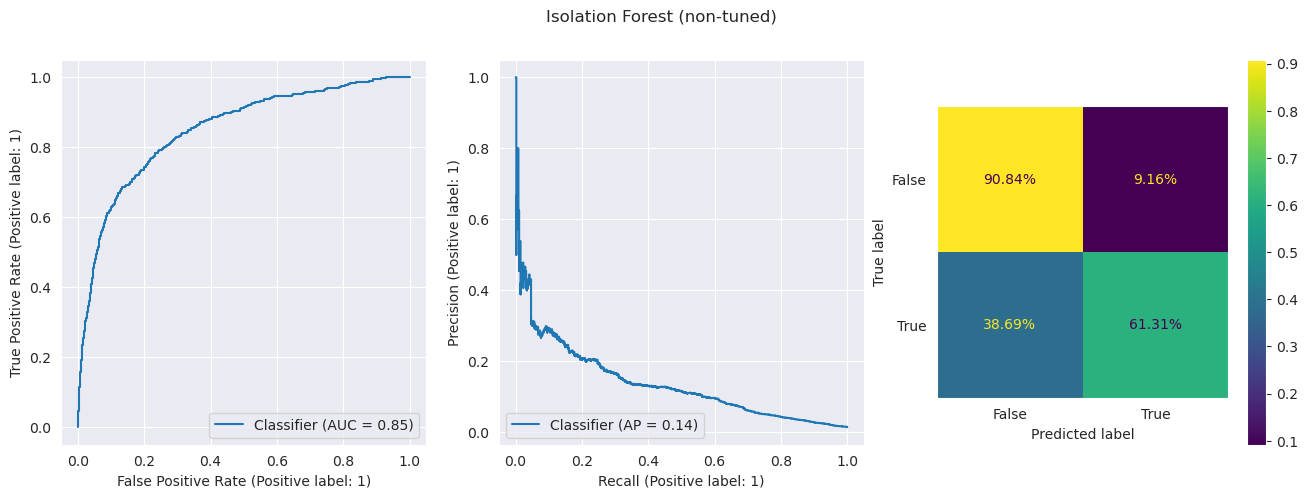

In [44]:
modelkey = "Isolation Forest"

model = IsolationForestWrapper(**if_params).fit(X_train_if[~y_train_if].to_numpy())
Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_if.to_numpy(),
    y_test_if,
    plot_title="Isolation Forest (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision   Recall  F1 Score  F2 Score       AUC       AUC_CI
Model  0.549618   0.028769  0.89852  0.055752  0.127513  0.849271  0.831-0.868

array([[17143, 14348],
       [   48,   425]])

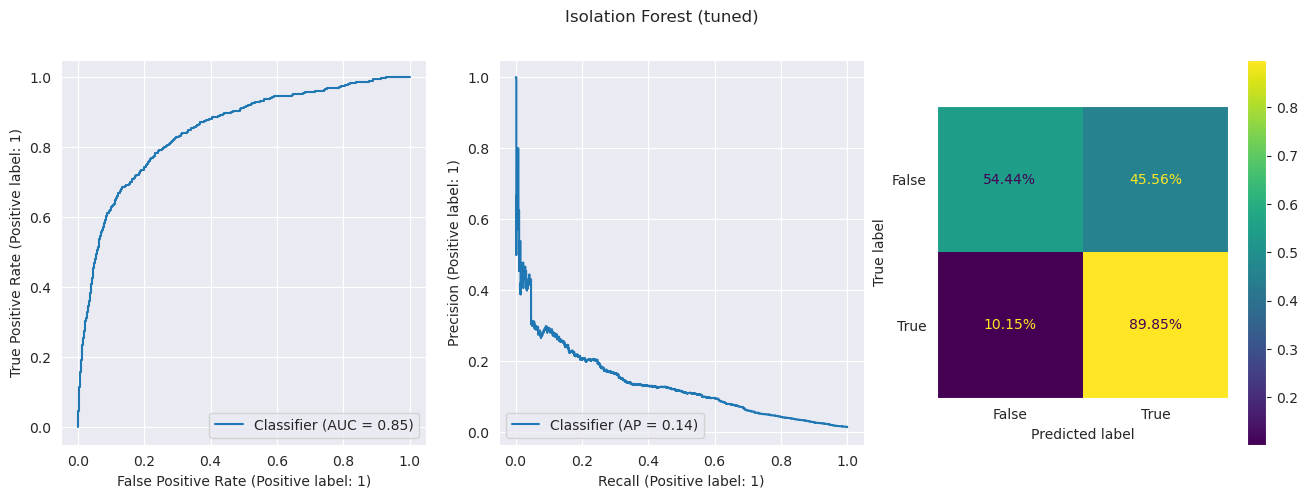

In [45]:
y_pred_proba_train = model.decision_function(X_train_if)
y_pred_proba_train -= y_pred_proba_train.min()

threshold = get_threshold(y_train_if, y_pred_proba_train,)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.decision_function(X_test_if)
y_pred = np.where(y_pred_proba - y_pred_proba.min() > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_if,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.543705   0.013606  0.939252  0.026823  0.064304  0.902723   

            AUC_CI  
Model  0.878-0.925

array([[17178, 14572],
       [   13,   201]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.544675   0.017194  0.878893  0.033727  0.079729  0.817611   

            AUC_CI  
Model  0.793-0.842

array([[17156, 14519],
       [   35,   254]])

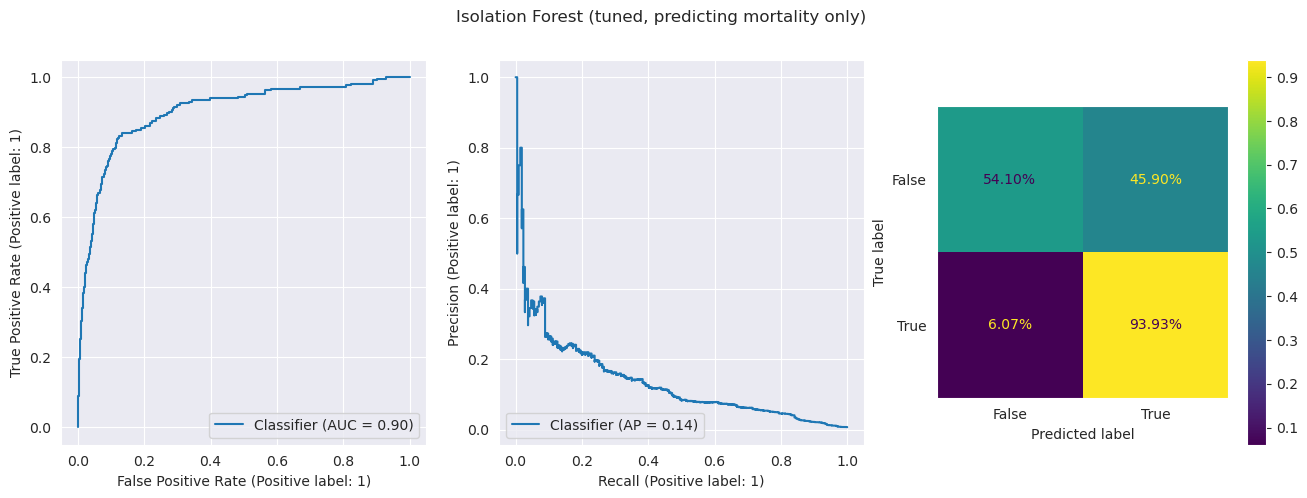

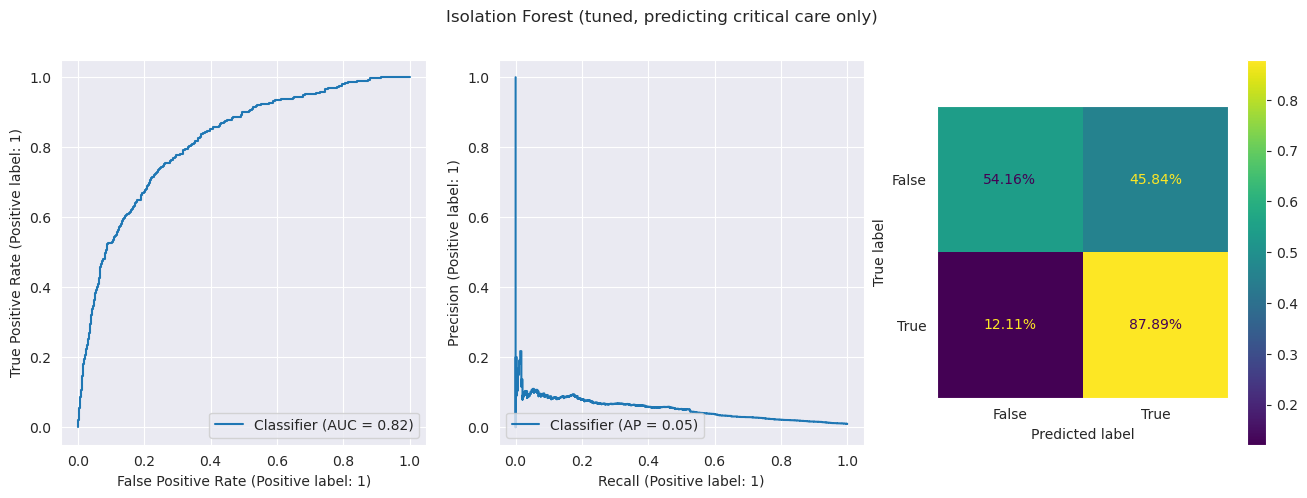

In [46]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


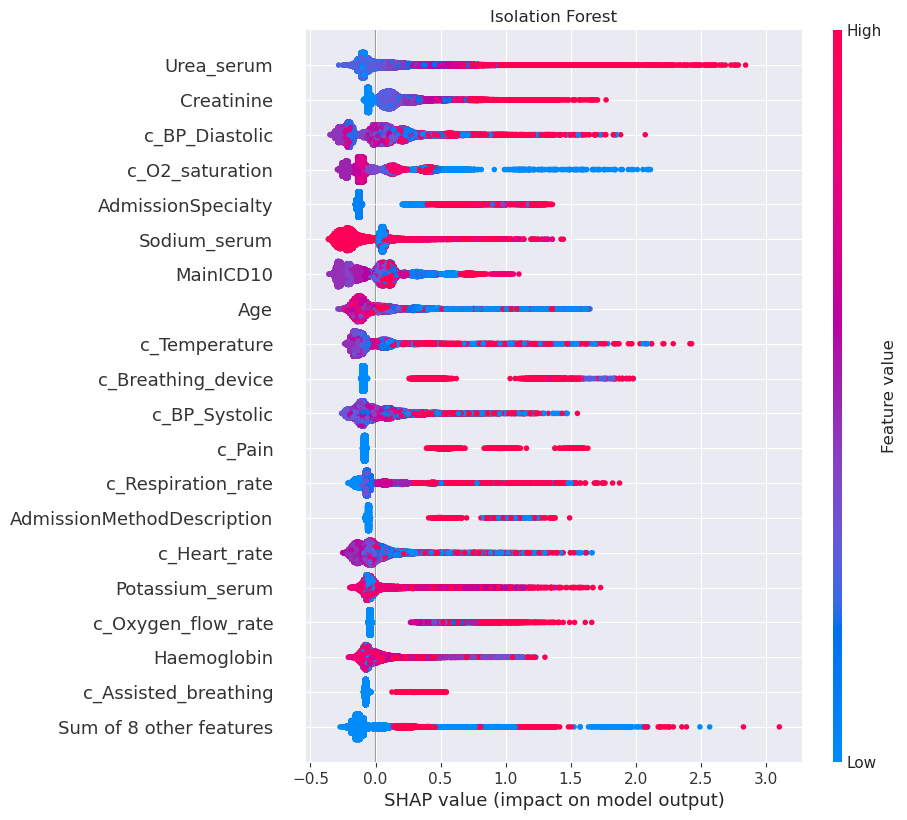

In [47]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_if)
shap_values.values = -shap_values.values  # Fix for isolation forest's unique labelling
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Isolation Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_isolation_forest.png", bbox_inches="tight"
    )



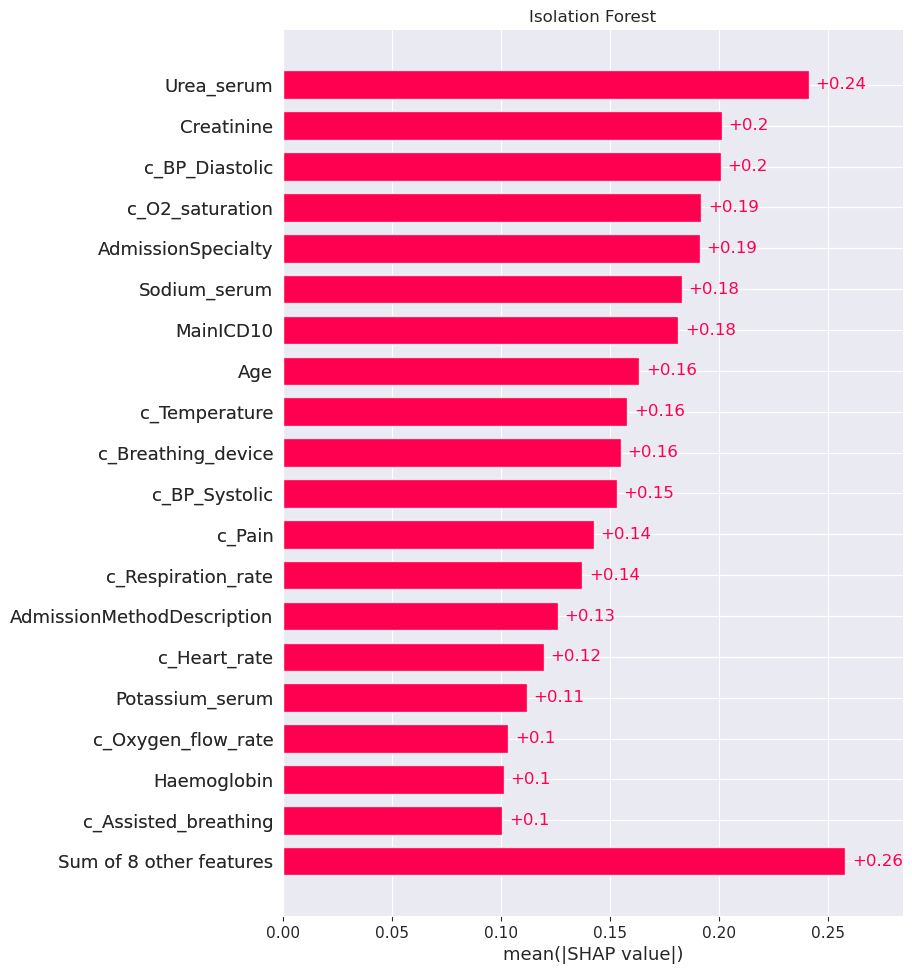

In [48]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Isolation Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_isolation_forest.png", bbox_inches="tight"
    )



### TabNet

In [2]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_params = dict(
    cat_idxs=categorical_cols_idx,
    cat_dims=categorical_cols_dims,
    n_a=64,
    n_d=64,
    n_steps=3,
    gamma=1.0,
    lambda_sparse=9e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.02, weight_decay=1e-05),
    mask_type="sparsemax",
    n_shared=1,
    scheduler_params=dict(mode="min", patience=5, min_lr=1e-05, factor=0.5,),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    verbose=0,
    device_name="cuda" if torch.cuda.is_available() else "cpu",
)

if Notebook.RUN_HYPERPARAMETERS:
    returned_params, tabnet_patience, tabnet_scheduler_patience = tune_tabnet(
        X_train,
        y_train,
        categorical_cols_idx,
        categorical_cols_dims,
        timeout=Notebook.HYPERPARAMETER_TIMEOUT,
        n_jobs=Notebook.HYPERPARAMETER_NJOBS,
    )

    tabnet_params.update(returned_params)
    tabnet_params["scheduler_params"]["patience"] = tabnet_scheduler_patience



BEST PARAMETERS
{'n_steps': 3, 'gamma': 1.4, 'lambda_sparse': 4.124103939134387e-06, 'mask_type': 'sparsemax', 'n_shared': 2, 'n_a': 60, 'n_d': 60}



Early stopping occurred at epoch 26 with best_epoch = 9 and best_valid_auc = 0.88549
Best weights from best epoch are automatically used!


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.923727   0.123995  0.684989  0.209981    0.3596  0.881864   

            AUC_CI  
Model  0.863-0.900

array([[29202,  2289],
       [  149,   324]])

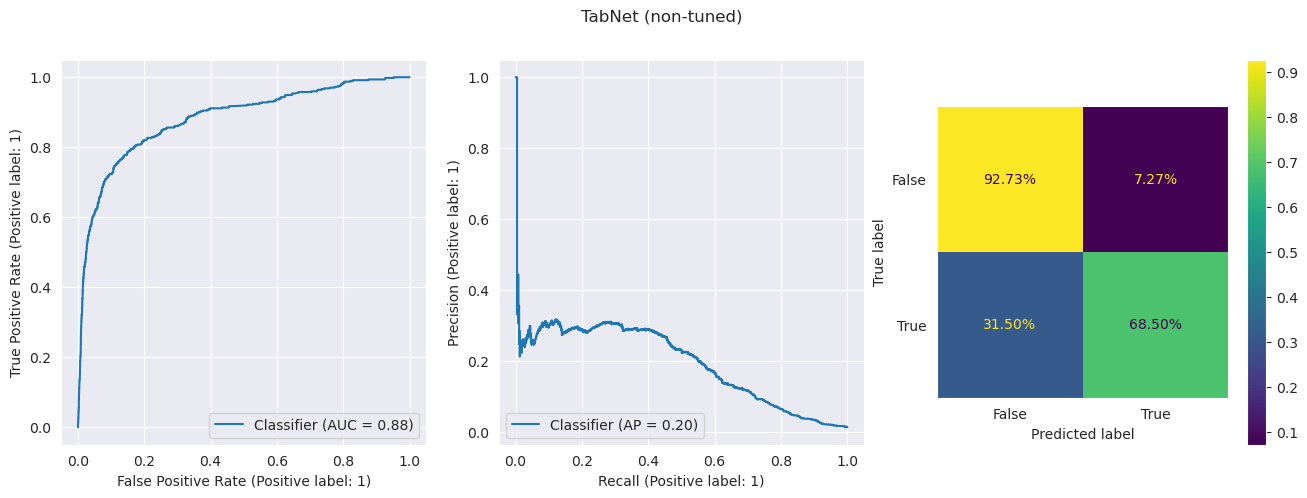

In [50]:
modelkey = "TabNet"
model = TabNetClassifier(**tabnet_params)
model.fit(
    X_train=X_train_tn,
    y_train=y_train_tn,
    eval_set=[(X_train_tn, y_train_tn), (X_valid_tn, y_valid_tn)],
    eval_name=["train", "valid"],
    eval_metric=["auc"],
    max_epochs=100,
    patience=tabnet_patience,
    # batch_size=512,
    # virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test.to_numpy(),
    y_test,
    "TabNet (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_tabnet.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.850644   0.073567  0.784355  0.134518  0.267484  0.881864   

            AUC_CI  
Model  0.863-0.900

array([[26819,  4672],
       [  102,   371]])

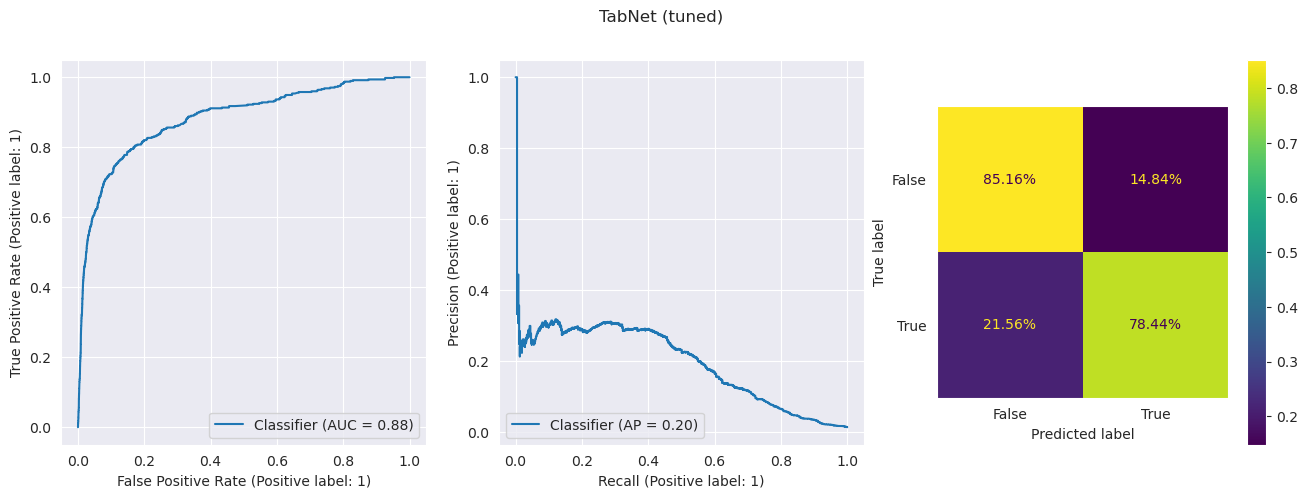

In [51]:
threshold = get_threshold(
    y_test, model.predict_proba(X_test.to_numpy())[:, 1], target=0.785
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test.to_numpy())[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_tabnet.png"
    if Notebook.SAVE_IMAGES
    else None,
)


Mortality


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.846296   0.034107  0.803738  0.065437  0.145787  0.888882   

            AUC_CI  
Model  0.864-0.911

array([[26879,  4871],
       [   42,   172]])

Critical Care


Accuracy  Precision    Recall  F1 Score  F2 Score       AUC  \
Model  0.847141    0.04422  0.771626  0.083646  0.179868  0.873458   

            AUC_CI  
Model  0.848-0.898

array([[26855,  4820],
       [   66,   223]])

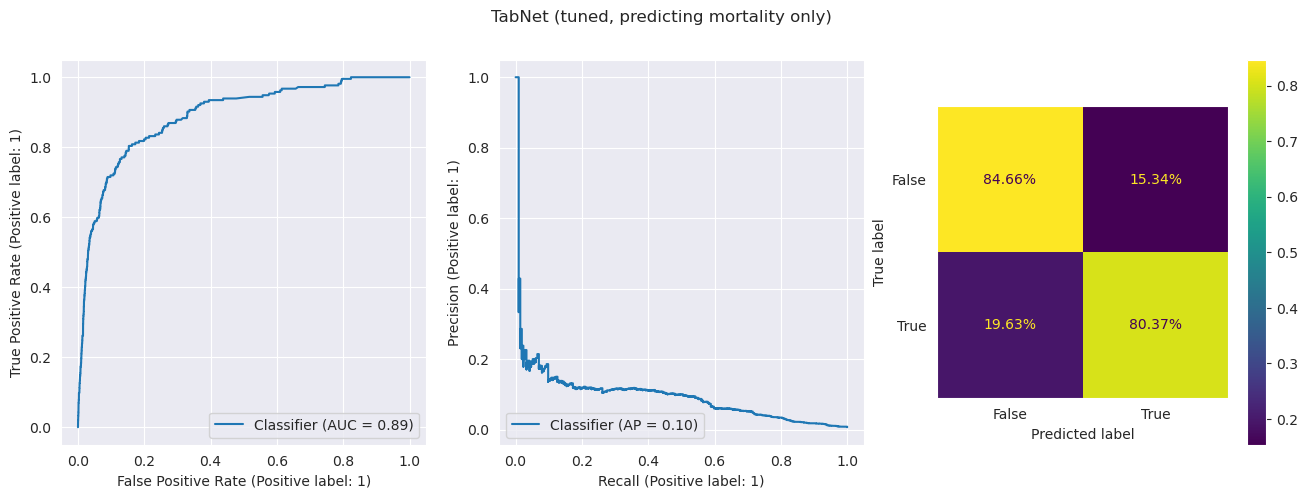

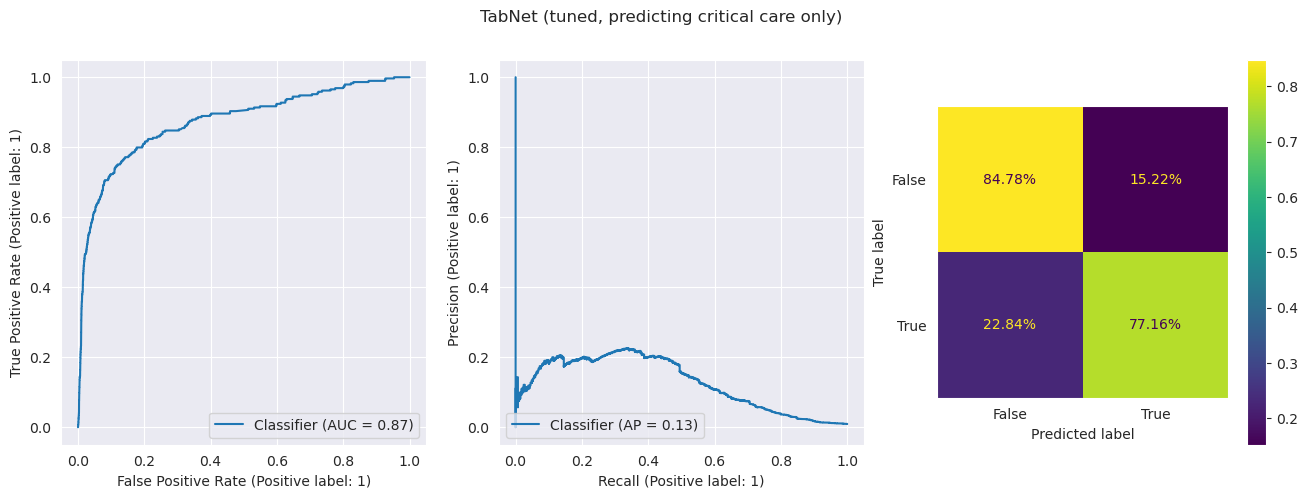

In [52]:
print("Mortality")
Notebook.MORTALITY_RESULTS[modelkey] = evaluate_from_pred(
    y_test_mortality,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned, predicting mortality only)",
    save=f"{Notebook.IMAGE_DIR}/eval_mortality_thresholded_tabnet.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)

print("Critical Care")
Notebook.CRITICALCARE_RESULTS[modelkey] = evaluate_from_pred(
    y_test_criticalcare,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned, predicting critical care only)",
    save=f"{Notebook.IMAGE_DIR}/eval_criticalcare_thresholded_tabnet.png"
    if Notebook.SAVE_IMAGES
    else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
)


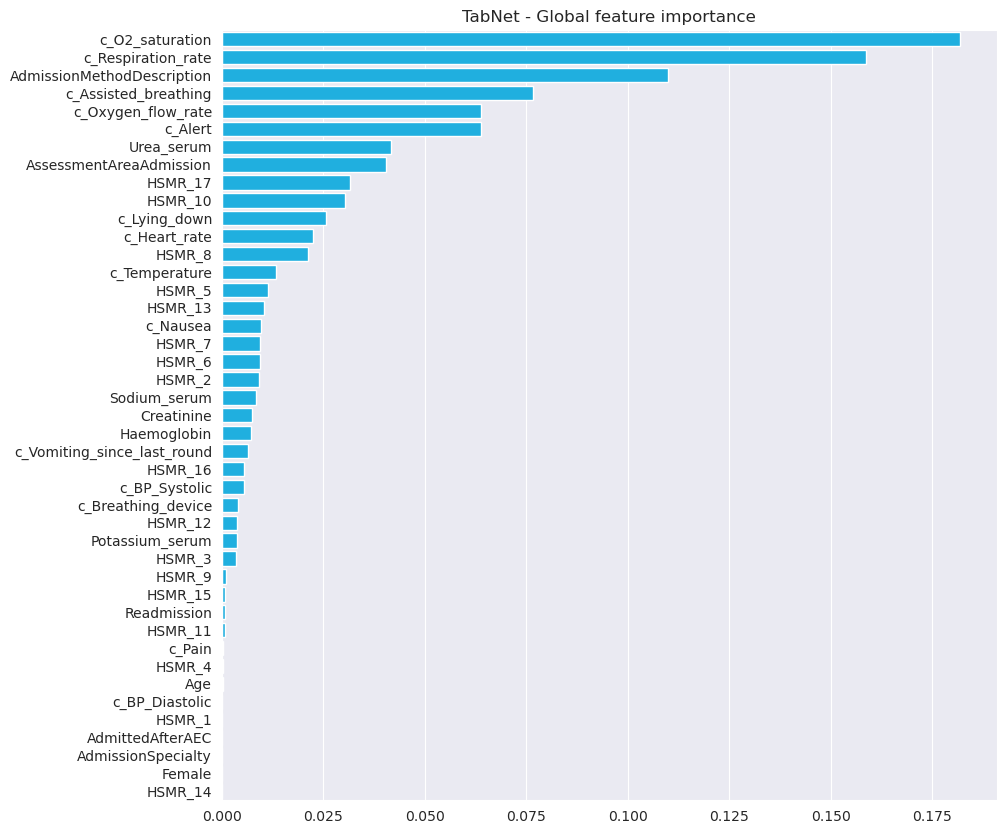

In [53]:
sorted_idx = model.feature_importances_.argsort()[::-1]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.barplot(
    x=model.feature_importances_[sorted_idx],
    y=X_train.columns[sorted_idx],
    color="deepskyblue",
    ax=ax
)
ax.set_title("TabNet - Global feature importance")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/global_weights_tabnet.png", bbox_inches="tight")



Using 1838 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/15000 [00:00<?, ?it/s]

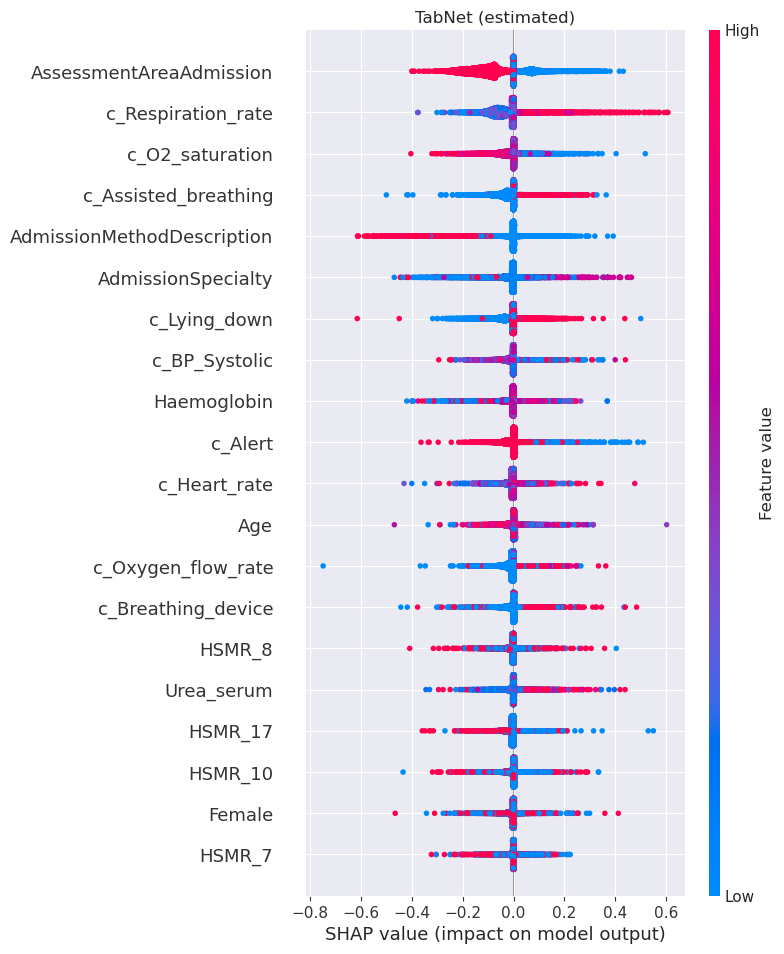

In [54]:
X_test_tn_shap = shap.sample(X_test.to_numpy(), 15000)
explainer = shap.KernelExplainer(model.predict_proba, np.concatenate((shap.sample(X_train_tn[~y_train_tn], 1000), X_train_tn[y_train_tn])))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(X_test_tn_shap, nsamples=50)

Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

shap.summary_plot(
    shap_values[1],
    X_test_tn_shap,
    feature_names=X_test.columns,
    show=False,
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    plot_type="dot",
)
plt.title("TabNet (estimated)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_tabnet.png", bbox_inches="tight")


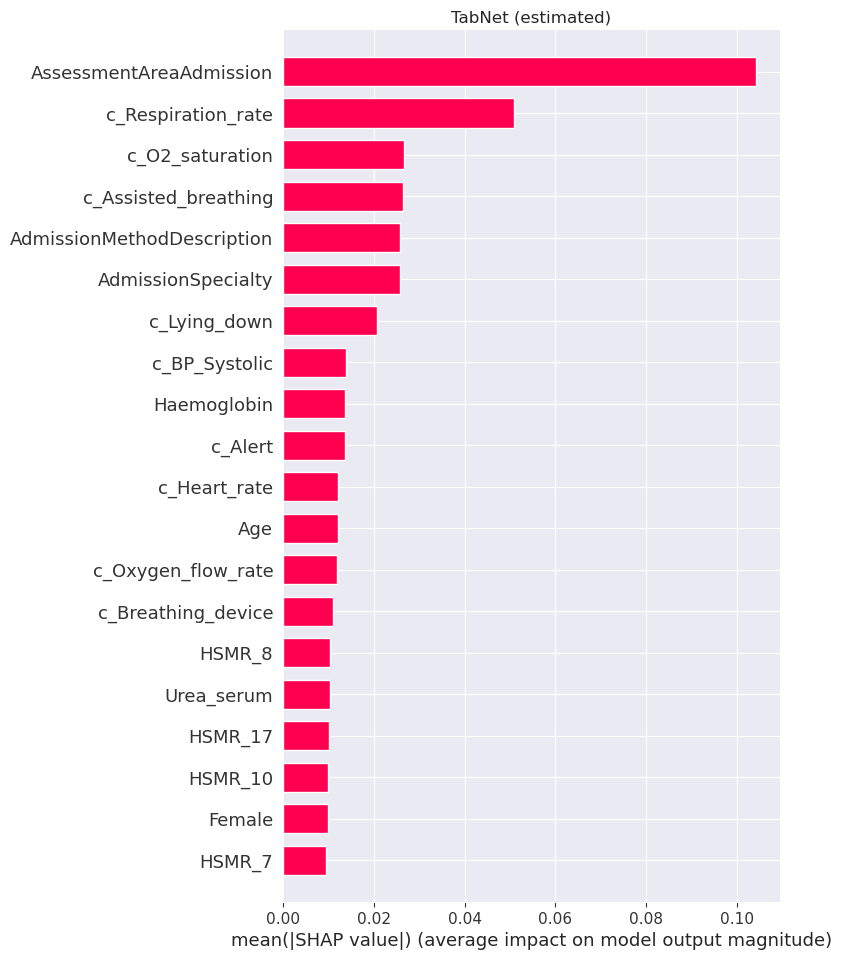

In [55]:
shap.summary_plot(
    shap_values[1],
    X_test_tn_shap,
    feature_names=X_test.columns,
    show=False,
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    plot_type="bar",
    color=shap.plots.colors.red_rgb,
)
plt.title("TabNet (estimated)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_tabnet.png", bbox_inches="tight")


In [56]:
if Notebook.SAVE_MODELS:
    with open(f"{Notebook.MODEL_DIR}/models.bin", "wb") as file:
        pickle.dump(Notebook.MODELS, file)

    with open(f"{Notebook.MODEL_DIR}/explainers.bin", "wb") as file:
        pickle.dump(Notebook.EXPLAINERS, file)


## Comparisons

### Scores

#### Pre-tuning scores

In [57]:
pd.concat(
    [results[0].assign(Model=key) for key, results in Notebook.EVAL_RESULTS.items()]
).set_index("Model")



Accuracy  Precision    Recall  F1 Score  \
Model                                                                      
Baseline (NEWS)                  0.975723   0.242784  0.302326  0.269303   
Logistic Regression (NEWS only)  0.860093   0.067301  0.657505  0.122104   
Logistic Regression              0.861813   0.082910  0.828753  0.150740   
Random Forest                    0.951414   0.196288  0.737844  0.310084   
XGBoost                          0.927137   0.145260  0.803383  0.246034   
LightGBM                         0.897885   0.111822  0.849894  0.197640   
Isolation Forest                 0.904017   0.091339  0.613108  0.158991   
TabNet                           0.923727   0.123995  0.684989  0.209981   

                                 F2 Score       AUC       AUC_CI  
Model                                                             
Baseline (NEWS)                  0.288190  0.825665  0.804-0.847  
Logistic Regression (NEWS only)  0.238753  0.823776  0.801-0.845  
Logistic Regression              0.296073  0.902988  0.886-0.920  
Random Forest                    0.475477  0.932882  0.920-0.945  
XGBoost                          0.421473  0.932242  0.918-0.945  
LightGBM                         0.366320  0.934812  0.922-0.947  
Isolation Forest                 0.286165  0.849271  0.831-0.868  
TabNet                           0.359600  0.881864  0.863-0.900

#### Post-tuning scores

In [58]:
pd.concat(
    [results[0].assign(Model=key) for key, results in Notebook.TUNED_RESULTS.items()]
).set_index("Model")



Accuracy  Precision    Recall  F1 Score  \
Model                                                                      
Logistic Regression (NEWS only)  0.549931   0.027251  0.847780  0.052805   
Logistic Regression              0.829965   0.069719  0.849894  0.128867   
Random Forest                    0.940464   0.169288  0.773784  0.277799   
XGBoost                          0.847735   0.080245  0.887949  0.147188   
LightGBM                         0.895445   0.109447  0.849894  0.193922   
Isolation Forest                 0.549618   0.028769  0.898520  0.055752   
TabNet                           0.850644   0.073567  0.784355  0.134518   

                                 F2 Score       AUC       AUC_CI  
Model                                                             
Logistic Regression (NEWS only)  0.120732  0.823776  0.801-0.845  
Logistic Regression              0.262471  0.902988  0.886-0.920  
Random Forest                    0.451406  0.932882  0.920-0.945  
XGBoost                          0.294695  0.932242  0.918-0.945  
LightGBM                         0.361186  0.934812  0.922-0.947  
Isolation Forest                 0.127513  0.849271  0.831-0.868  
TabNet                           0.267484  0.881864  0.863-0.900

### ROC

In [59]:
roc_dict, pr_dict = (
    {key: val[1] for key, val in Notebook.EVAL_RESULTS.items()},
    {key: val[2] for key, val in Notebook.EVAL_RESULTS.items()},
)



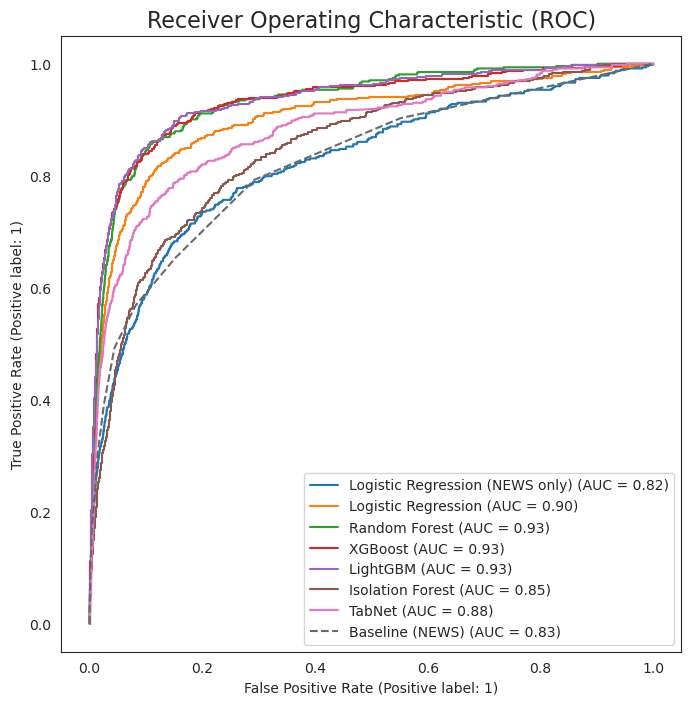

In [60]:
joint_plot(
    roc_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_roc_curve"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Receiver Operating Characteristic (ROC)",
)


### Precision-Recall

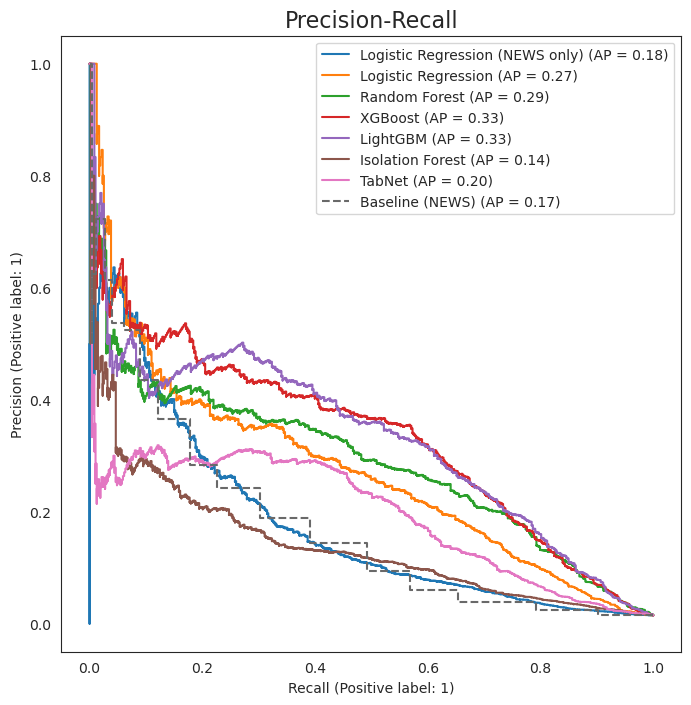

In [61]:
joint_plot(
    pr_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_pr_curve"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Precision-Recall",
    legend_location="upper right",
)


### Side-by-side

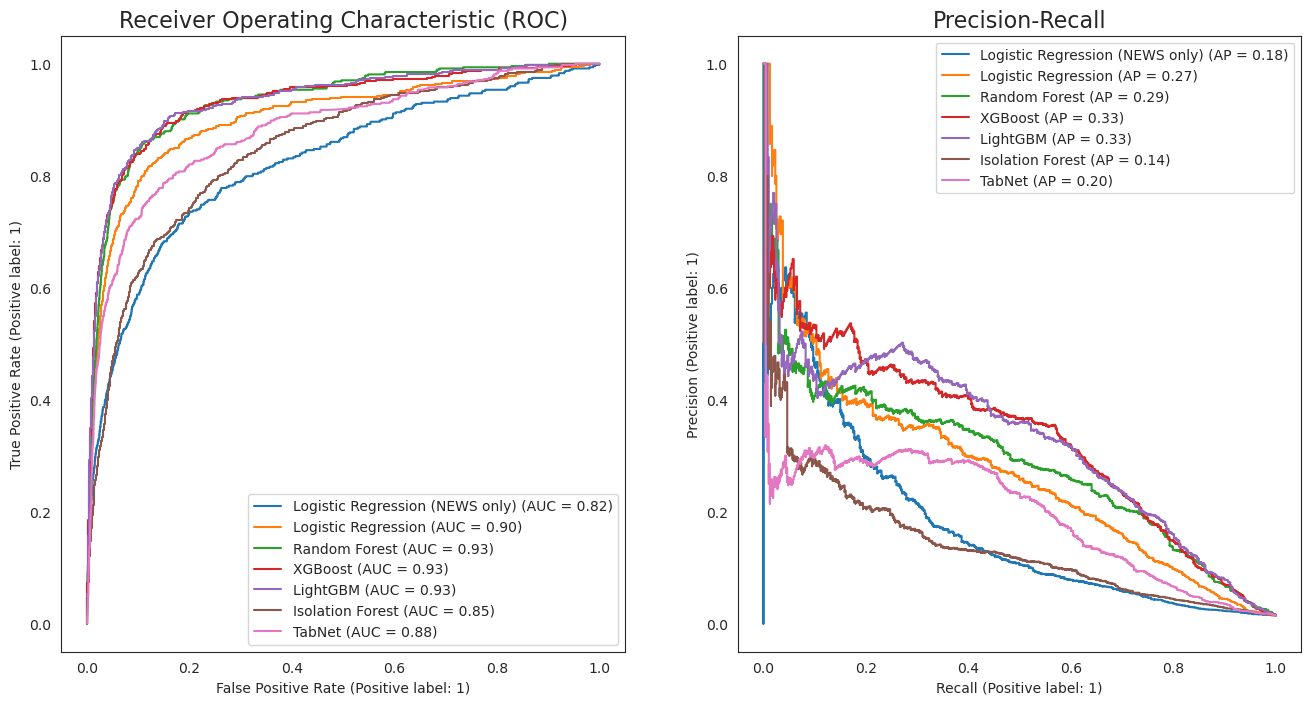

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict,
    ax=ax[1],
    title="Precision-Recall",
    legend_location="upper right",
    plot_baseline=False,
)
joint_plot(
    roc_dict,
    ax=ax[0],
    title="Receiver Operating Characteristic (ROC)",
    plot_baseline=False,
)

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/combined_curves_no_baseline.png", bbox_inches="tight"
    )



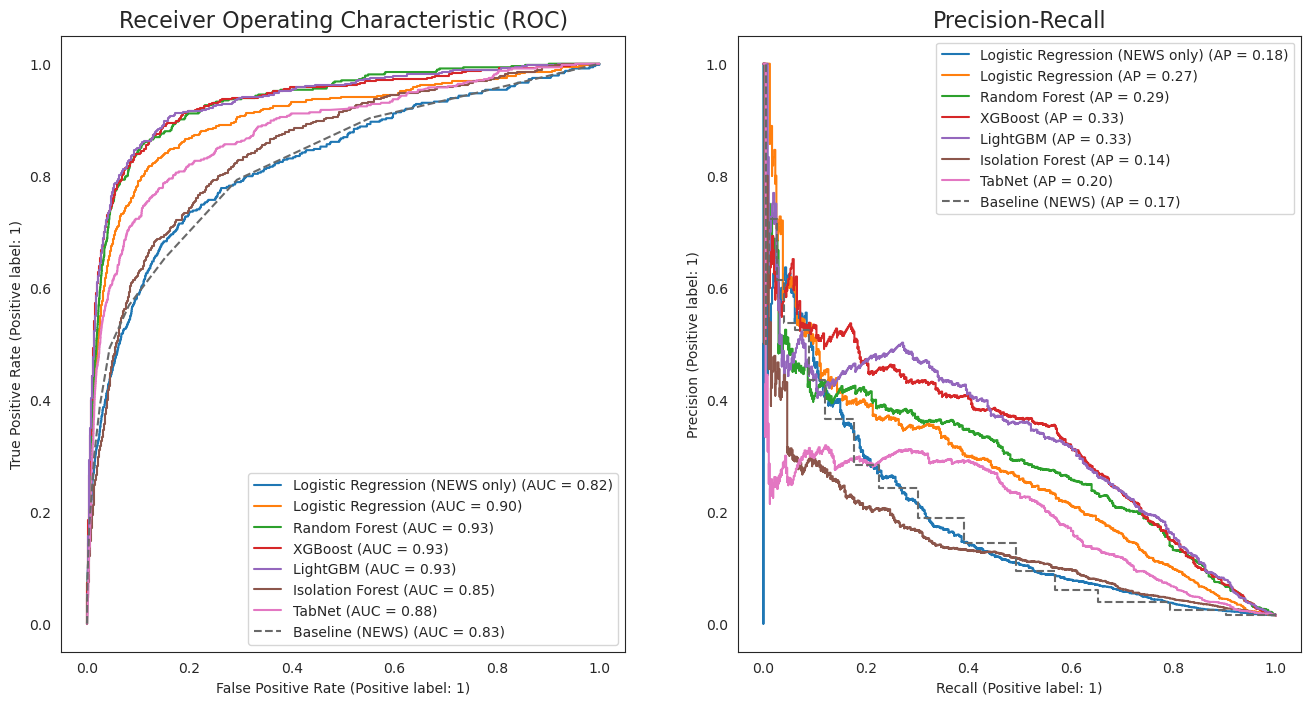

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title="Precision-Recall", legend_location="upper right",
)
joint_plot(
    roc_dict, ax=ax[0], title="Receiver Operating Characteristic (ROC)",
)

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/combined_curves.png", bbox_inches="tight")


### SHAP Explanations (Setup - skip to next section)

In [64]:
y_preds = pd.DataFrame(
    {
        key: model.predict(
            {
                "LightGBM": X_test,
                "Isolation Forest": X_test_if,
                "TabNet": X_test.to_numpy(),
                "XGBoost": X_test,
                "Random Forest": X_test,
                "Logistic Regression": X_test,
            }[key]
        )
        for key, model in Notebook.MODELS.items()
        if key != "Logistic Regression (NEWS only)"
    }
)

candidates = y_preds[y_preds.all(axis=1)].index

patient = candidates[0]
patient_data = X_test.iloc[patient].apply(
    lambda x: f"{x:.2f}" if type(x) == np.float64 else x
)
patient_data_if = X_test_if.iloc[patient].copy()
patient_data_if.update(X_test.iloc[patient])

explanations = {
    modelkey: shap_values[patient]
    for modelkey, (_, shap_values) in Notebook.EXPLAINERS.items()
    if not modelkey in ["TabNet", "Logistic Regression (NEWS only)"]
}
for _ in explanations.keys():
    if len(explanations[_].shape) > 1:
        explanations[_] = explanations[_][:, 1]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    tabnet_explainer = Notebook.EXPLAINERS["TabNet"][0]
    explanations["TabNet"] = shap.Explanation(
        tabnet_explainer.shap_values(X_test.to_numpy()[patient])[1],
        data=patient_data.values,
        base_values=tabnet_explainer.expected_value[1],
        feature_names=patient_data.index,
    )



### SHAP Force Plots

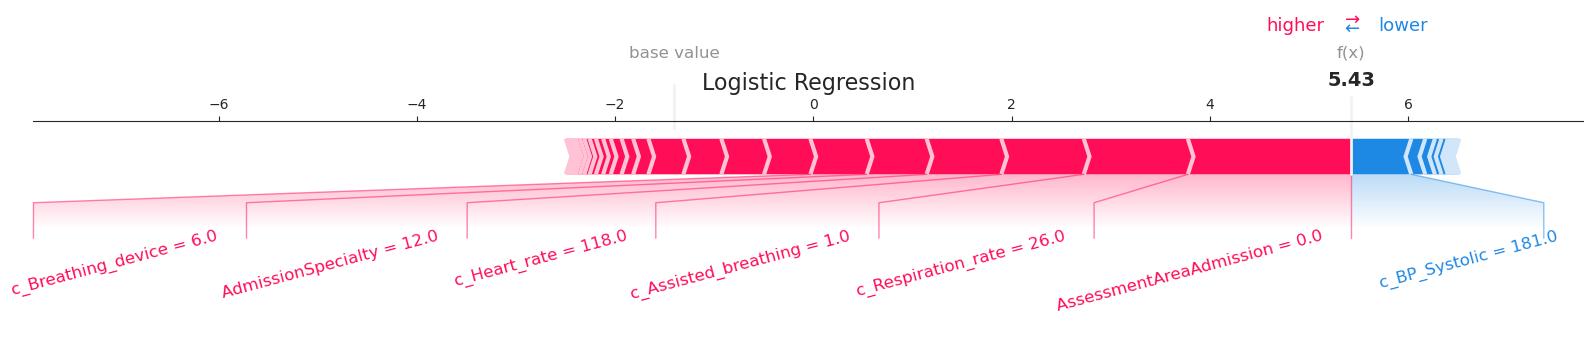

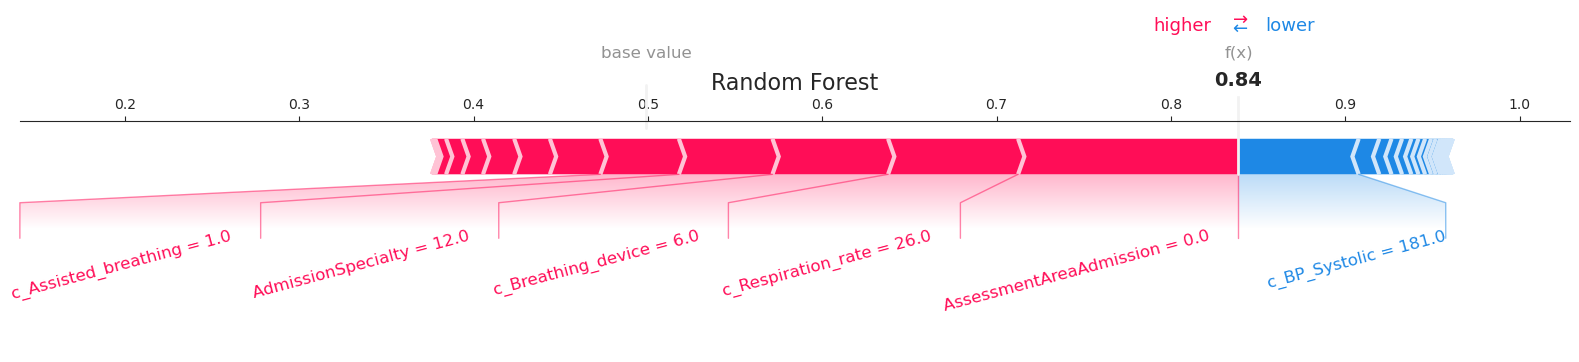

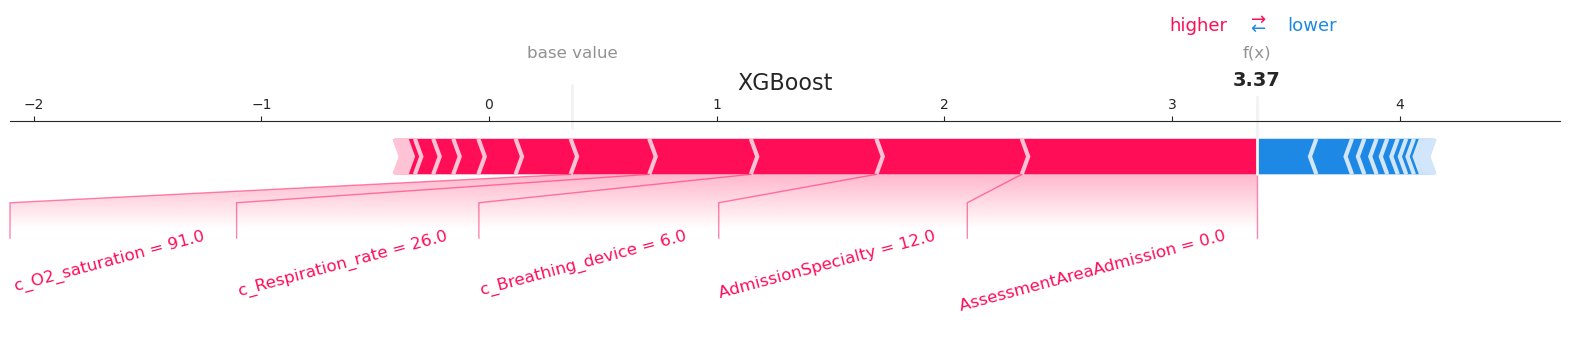

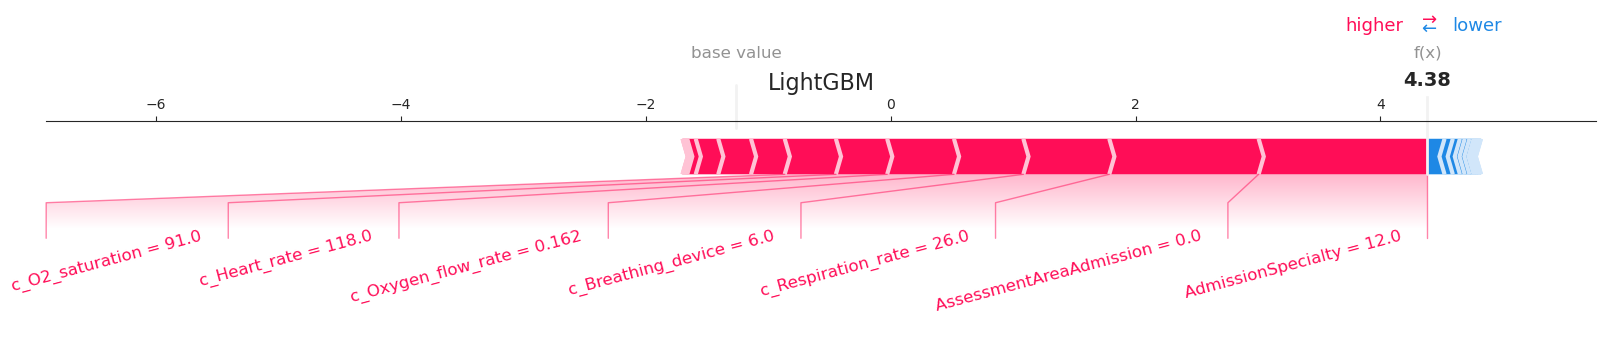

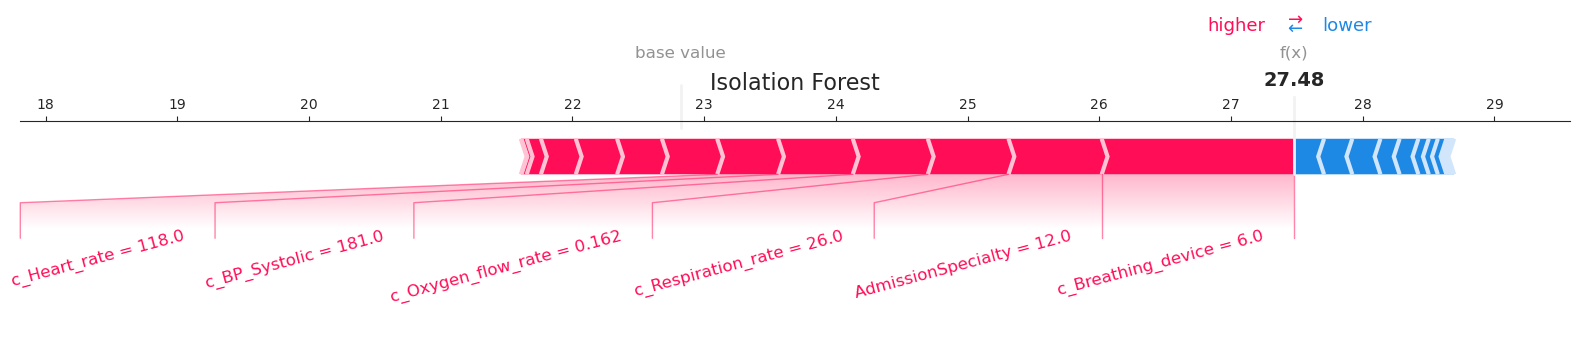

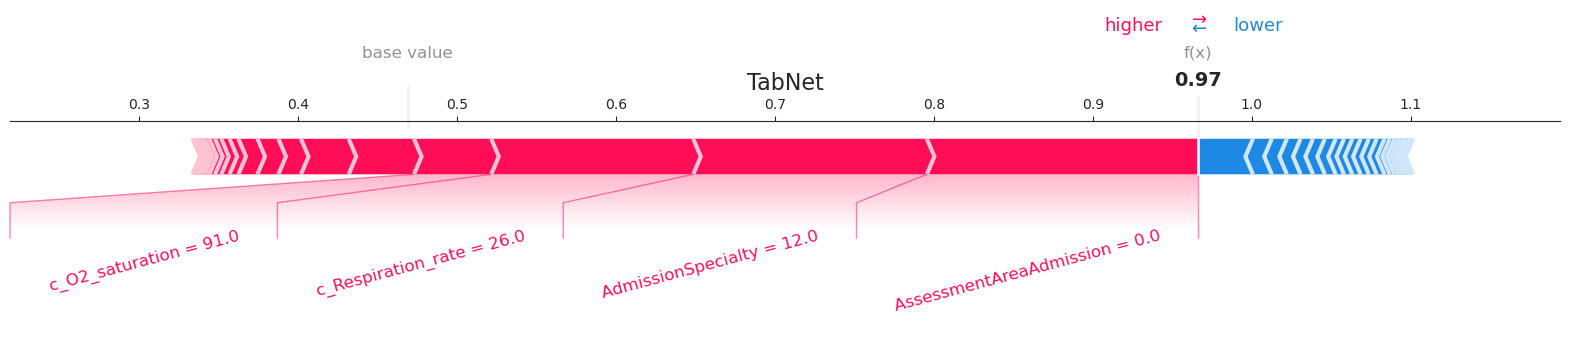

In [65]:
sns.set_style("white")
plt.rc("axes", titlesize=16)
for modelkey, explanation in explanations.items():
    patient_to_use = patient_data if modelkey != "Isolation Forest" else patient_data_if

    explanation = shap.Explanation(explanation)
    explanation.data = patient_to_use.values

    fig = shap.plots.force(
        explanation,
        feature_names=patient_to_use.index,
        matplotlib=True,
        contribution_threshold=0.08,
        show=False,
        text_rotation=15,
    )

    plt.title(modelkey)
    display(fig)

    if Notebook.SAVE_IMAGES:
        plt.savefig(
            f"{Notebook.IMAGE_DIR}/comaprison_force_plot_{modelkey.replace(' ','')}.png",
            bbox_inches="tight",
        )

    plt.clf()

sns.set_style("darkgrid")



### Mortality-only Results

In [66]:
pd.concat(
    [
        results[0].assign(Model=key)
        for key, results in Notebook.MORTALITY_RESULTS.items()
    ]
).set_index("Model")



Accuracy  Precision    Recall  F1 Score  \
Model                                                                      
Baseline (NEWS)                  0.982386   0.203735  0.560748  0.298879   
Logistic Regression (NEWS only)  0.545332   0.013456  0.925234  0.026526   
Logistic Regression              0.824115   0.031044  0.836449  0.059866   
Random Forest                    0.935490   0.072618  0.733645  0.132155   
XGBoost                          0.841321   0.035919  0.878505  0.069016   
LightGBM                         0.889532   0.048462  0.831776  0.091587   
Isolation Forest                 0.543705   0.013606  0.939252  0.026823   
TabNet                           0.846296   0.034107  0.803738  0.065437   

                                 F2 Score       AUC       AUC_CI  
Model                                                             
Baseline (NEWS)                  0.415225  0.924936  0.903-0.945  
Logistic Regression (NEWS only)  0.063580  0.901883  0.875-0.927  
Logistic Regression              0.135156  0.900876  0.875-0.924  
Random Forest                    0.260106  0.921623  0.901-0.940  
XGBoost                          0.154351  0.923020  0.900-0.943  
LightGBM                         0.196511  0.929449  0.910-0.947  
Isolation Forest                 0.064304  0.902723  0.878-0.925  
TabNet                           0.145787  0.888882  0.864-0.911

In [67]:
roc_dict, pr_dict = (
    {key: val[1] for key, val in Notebook.MORTALITY_RESULTS.items()},
    {key: val[2] for key, val in Notebook.MORTALITY_RESULTS.items()},
)

joint_plot(
    roc_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_roc_curve_mortality"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Receiver Operating Characteristic (predicting mortality only)",
)

joint_plot(
    pr_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_pr_curve_mortality"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Precision-Recall (predicting mortality only)",
    legend_location="upper right",
)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title="Precision-Recall", legend_location="upper right",
)
joint_plot(
    roc_dict, ax=ax[0], title="Receiver Operating Characteristic (ROC)",
)

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/combined_curves_mortality.png", bbox_inches="tight"
    )


### Critical care-only results

In [68]:
roc_dict, pr_dict = (
    {key: val[1] for key, val in Notebook.CRITICALCARE_RESULTS.items()},
    {key: val[2] for key, val in Notebook.CRITICALCARE_RESULTS.items()},
)

joint_plot(
    roc_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_roc_curve_criticalcare"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Receiver Operating Characteristic (predicting critical care only)",
)

joint_plot(
    pr_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_pr_curve_criticalcare"
    if Notebook.SAVE_IMAGES
    else None,
    ax=None,
    title="Precision-Recall (predicting critical care only)",
    legend_location="upper right",
)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title="Precision-Recall", legend_location="upper right",
)
joint_plot(
    roc_dict, ax=ax[0], title="Receiver Operating Characteristic (ROC)",
)

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/combined_curves_criticalcare.png", bbox_inches="tight"
    )
